### Travail réalisé par :                                                                           
            CHAIKHI Belaid 
            BOUGHANMI Chaima

# Libraries

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
import pandas as pd
import os
import scipy.optimize as optimize
from scipy.optimize import broyden1
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import scipy.stats as ss
import scipy.optimize as scpo

import scipy.stats as st
import numpy as np
import math
import matplotlib.pyplot as pl
import numpy as np
from numpy import *
import scipy as sp
import scipy.stats as stats

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend, Input
from keras.constraints import non_neg

%matplotlib inline

# Helper functions :

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import numpy as np
import pandas as pd
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.optimize as scpo
from functools import partial
from itertools import compress
import os
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import fsolve
class Option_param():
    """
    Option class wants the option parameters:
    S0 = current stock price
    K = Strike price
    T = time to maturity
    v0 = (optional) spot variance 
    exercise = European or American
    """
    def __init__(self, S0=15, K=15, T=1, v0=0.04, payoff="call", exercise="European"):
        self.S0 = S0
        self.v0 = v0
        self.K = K
        self.T = T
        
        if (exercise=="European" or exercise=="American"):
            self.exercise = exercise
        else: 
            raise ValueError("invalid type. Set 'European' or 'American'")
        
        if (payoff=="call" or payoff=="put"):
            self.payoff = payoff
        else: 
            raise ValueError("invalid type. Set 'call' or 'put'")

class Diffusion_process():
    """
    Class for the diffusion process:
    r = risk free constant rate
    sig = constant diffusion coefficient
    mu = constant drift 
    """
    def __init__(self, r=0.1, sig=0.2, mu=0.1):
        self.r = r
        self.mu = mu
        if (sig<=0):
            raise ValueError("sig must be positive")
        else:
            self.sig = sig

    def exp_RV(self, S0, T, N):
        W = ss.norm.rvs( (self.r-0.5*self.sig**2)*T , np.sqrt(T)*self.sig, N )
        S_T = S0 * np.exp(W)
        return S_T.reshape((N,1))
    
class Heston_process():
    """
    Class for the Heston process:
    r = risk free constant rate
    rho = correlation between stock noise and variance noise
    theta = long term mean of the variance process
    sigma = volatility coefficient of the variance process
    kappa = mean reversion coefficient for the variance process
    """
    def __init__(self, mu=0.1, rho=0, sigma=0.2, theta=-0.1, kappa=0.1):
        self.mu = mu
        if (np.abs(rho)>1):
            raise ValueError("|rho| must be <=1")
        self.rho = rho
        if (theta<0 or sigma<0 or kappa<0):
            raise ValueError("sigma,theta,kappa must be positive")
        else:
            self.theta = theta
            self.sigma = sigma
            self.kappa = kappa

def cf_normal(u, mu=1, sig=2):
    """
    Characteristic function of a Normal random variable
    """
    return np.exp( 1j * u * mu - 0.5 * u**2 * sig**2 )




            
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi+d)*t - 2*np.log( (1-g1*np.exp(d*t))/(1-g1) ))\
              + (v0/sigma**2)*(xi+d) * (1-np.exp(d*t))/(1-g1*np.exp(d*t)) )
    return cf


def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g1 = (xi+d)/(xi-d)
    g2 = 1/g1
    cf = np.exp( 1j*u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
              + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
    return cf


def Q1(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the stock numeraire.
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( (np.exp(-u*k*1j) / (u*1j)) * 
                                  cf(u-1j) / cf(-1.0000000000001j) )  
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]


def Q2(k, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the money market numeraire
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( np.exp(-u*k*1j) /(u*1j) * cf(u) )
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=2000 )[0]
def fft_Lewis(K, S0, r, T, cf, interp="cubic"):
    """ 
    K = vector of strike
    S = spot price scalar
    cf = characteristic function
    interp can be cubic or linear
    """
    N=2**15                          # FFT more efficient for N power of 2
    B = 500                          # integration limit 
    dx = B/N
    x = np.arange(N) * dx            # the final value B is excluded

    weight = np.arange(N)            # Simpson weights
    weight = 3 + (-1)**(weight+1)
    weight[0] = 1; weight[N-1]=1

    dk = 2*np.pi/B
    b = N * dk /2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(- 1j * b * np.arange(N)*dx) * cf(x - 0.5j) * 1/(x**2 + 0.25) * weight * dx/3
    integral_value = np.real( ifft(integrand)*N )
    
    if interp == "linear":
        spline_lin = interp1d(ks, integral_value, kind='linear')
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_lin( np.log(S0/K) )
    elif interp == "cubic":
        spline_cub = interp1d(ks, integral_value, kind='cubic')
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub( np.log(S0/K) )
    return prices


def IV_from_Lewis(K, S0, T, r, cf, disp=False):
    """ Implied Volatility from the Lewis formula 
    K = strike; S0 = spot stock; T = time to maturity; r = interest rate
    cf = characteristic function """
    k = np.log(S0/K)
    def obj_fun(sig):
        integrand = lambda u: np.real( np.exp(u*k*1j)\
                            * (cf(u - 0.5j) - np.exp(1j*u*r*T+0.5*r*T) * np.exp(-0.5*T*(u**2+0.25)*sig**2) ) )\
                            * 1/(u**2 + 0.25)
        int_value = quad(integrand, 1e-15, 2000, limit=2000, full_output=1 )[0]
        return int_value
    
    X0 = [0.2, 1, 2, 4, 0.0001]   # set of initial guess points
    for x0 in X0:
        x, _, solved, msg = fsolve( obj_fun, [x0,], full_output=True, xtol=1e-4)
        if solved == 1:
            return x[0]    
    if disp == True:
        print("Strike", K, msg)
    return -1

class Heston_pricer():
    """
    Class to price the options with the Heston model by: Fourier-inversion.
    """
    def __init__(self, Option_info, Process_info ):
        """
        Process_info:  of type VG_process. It contains the interest rate r and the VG parameters (sigma, theta, kappa) 
    
        Option_info:  of type Option_param. It contains (S0,K,T) i.e. current price, strike, maturity in years
        """
        self.r = Process_info.mu              # interest rate
        self.sigma = Process_info.sigma       # Heston parameter
        self.theta = Process_info.theta       # Heston parameter
        self.kappa = Process_info.kappa       # Heston parameter
        self.rho = Process_info.rho           # Heston parameter
        
        self.S0 = Option_info.S0          # current price
        self.v0 = Option_info.v0          # spot variance
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff


   


    def Fourier_inversion(self):
        """
        Price obtained by inversion of the characteristic function
        """
        k = np.log(self.K/self.S0)                # log moneyness
        cf_H_b_good = partial(cf_Heston_good, t=self.T, v0=self.v0, mu=self.r, theta=self.theta, 
                                  sigma=self.sigma, kappa=self.kappa, rho=self.rho ) 
        
        limit_max = 2000      # right limit in the integration                
        
        if self.payoff == "call":
            call = self.S0 * Q1(k, cf_H_b_good, limit_max) \
                                                - self.K * np.exp(-self.r*self.T) * Q2(k, cf_H_b_good, limit_max)
            return call
        elif self.payoff == "put":
            put = self.K * np.exp(-self.r*self.T) * (1 - Q2(k, cf_H_b_good, limit_max)) \
                                                - self.S0 * (1-Q1(k, cf_H_b_good, limit_max))
            return put
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")


    def FFT(self, K):
        """
        FFT method. It returns a vector of prices.
        K is an array of strikes
        """
        K = np.array(K)
        cf_H_b_good = partial(cf_Heston_good, t=self.T, v0=self.v0, mu=self.r, theta=self.theta, 
                                  sigma=self.sigma, kappa=self.kappa, rho=self.rho ) 
        
        if self.payoff == "call":
            return fft_Lewis(K, self.S0, self.r, self.T, cf_H_b_good, interp="cubic")
        elif self.payoff == "put":        # put-call parity
            return fft_Lewis(K, self.S0, self.r, self.T, cf_H_b_good, interp="cubic") - self.S0 + K*np.exp(-self.r*self.T)
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
            

## Heston Formula

In [4]:
def HestonFormula(r, T, K, S0, v0, kappa, theta, sigma, payoff, exercise="European"):
    """
    Price option using Heston Model 
    """
    opt_param = Option_param(S0=S0, K=K, T=T, v0=v0, exercise=exercise, payoff=payoff )
    Heston_param = Heston_process(mu=r, sigma=sigma, theta=theta, kappa=kappa) 
    Hest = Heston_pricer(opt_param, Heston_param)
    Hest_Price=Hest.FFT([K])[0]
    return Hest_Price


# Question 1

Dans cette exercice on crée un modèle de prédiction avec GPR et avec un réseau de neuronne 
simple pour prédire les prix d'un call suivant le modèle de Heston à partir des valeurs de S0 et T

# Heston Model Parameteres

In [5]:
r=0.05
K=100
v0=0.1
kappa=2
theta=0.1
sigma=0.2
payoff="call"#call ou put
exercise="European"#european ou American

## GPR

In [6]:
Heston_Call_Price = lambda s,t: HestonFormula(r,t*5+(1-t)*1,K,s*100+(1-s)*30, v0, kappa, theta, sigma, payoff, exercise)

In [9]:
training_number = 200   # taille de data de train
testing_number =  1000  # taille de data de teste
# les S0 et T 
train_s = torch.rand(1,training_number)
train_t = torch.rand(1,training_number)
test_s = torch.rand(1,testing_number)
test_t = torch.rand(1,testing_number)

# Liste de prix d'entrainements (train_y)
Heston_price_train=[]
for i in range(training_number):
    hest_price=Heston_Call_Price(np.array(train_s)[0][i], np.array(train_t)[0][i])
    Heston_price_train.append(hest_price)

# Liste de prix de test (test_y)
Heston_price_test=[]
for i in range(testing_number):
    hest_price=Heston_Call_Price(np.array(test_s)[0][i], np.array(test_t)[0][i])
    Heston_price_test.append(hest_price)
    
train_x=torch.stack([train_s, train_t], -1)
test_x=torch.stack([test_s, test_t], -1)
train_y=torch.FloatTensor(np.array(Heston_price_train).reshape(1, training_number))
test_y=torch.FloatTensor(np.array(Heston_price_test).reshape(1, testing_number))

In [10]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=1
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)), num_tasks=1, rank=1
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [11]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=1)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.lengthscale, likelihood.noise))
    
    optimizer.step()

Iter 1/100 - Loss: 5.090 lengthscale: 0.693 noise: 0.693
Iter 2/100 - Loss: 4.493 lengthscale: 0.644 noise: 0.744
Iter 3/100 - Loss: 3.994 lengthscale: 0.599 noise: 0.795
Iter 4/100 - Loss: 3.586 lengthscale: 0.559 noise: 0.841
Iter 5/100 - Loss: 3.255 lengthscale: 0.523 noise: 0.877
Iter 6/100 - Loss: 2.985 lengthscale: 0.493 noise: 0.900
Iter 7/100 - Loss: 2.762 lengthscale: 0.468 noise: 0.908
Iter 8/100 - Loss: 2.575 lengthscale: 0.448 noise: 0.903
Iter 9/100 - Loss: 2.415 lengthscale: 0.433 noise: 0.886
Iter 10/100 - Loss: 2.276 lengthscale: 0.421 noise: 0.861
Iter 11/100 - Loss: 2.155 lengthscale: 0.413 noise: 0.829
Iter 12/100 - Loss: 2.047 lengthscale: 0.407 noise: 0.793
Iter 13/100 - Loss: 1.951 lengthscale: 0.404 noise: 0.754
Iter 14/100 - Loss: 1.863 lengthscale: 0.403 noise: 0.713
Iter 15/100 - Loss: 1.783 lengthscale: 0.403 noise: 0.670
Iter 16/100 - Loss: 1.709 lengthscale: 0.405 noise: 0.628
Iter 17/100 - Loss: 1.640 lengthscale: 0.409 noise: 0.586
Iter 18/100 - Loss: 1.5

In [12]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat = likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

In [13]:
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
lengthscale = model.covar_module.data_covar_module.base_kernel.lengthscale
sigma_2_n = likelihood.noise
nu = model.covar_module.data_covar_module.base_kernel.nu
print(lengthscale, sigma_2_n, nu, Omega, sep='\n')

tensor([[1.4280]], grad_fn=<SoftplusBackward0>)
tensor([0.0002], grad_fn=<AddBackward0>)
2.5
[[19.000393]]


Text(0.5, 1.0, 'Real and Predicted Heston Call Prices in respect to T')

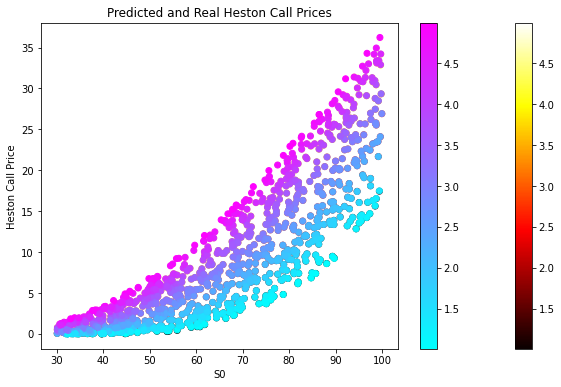

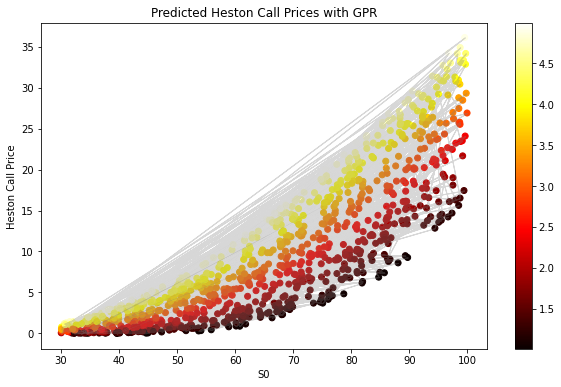

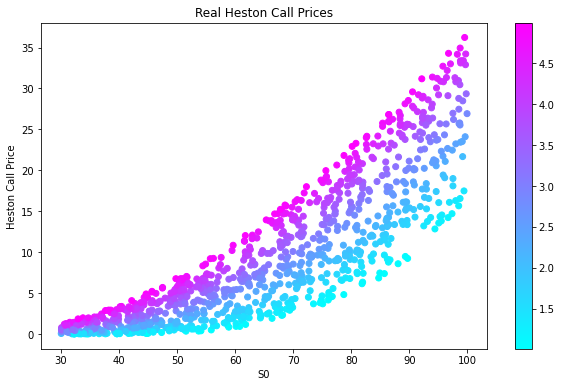

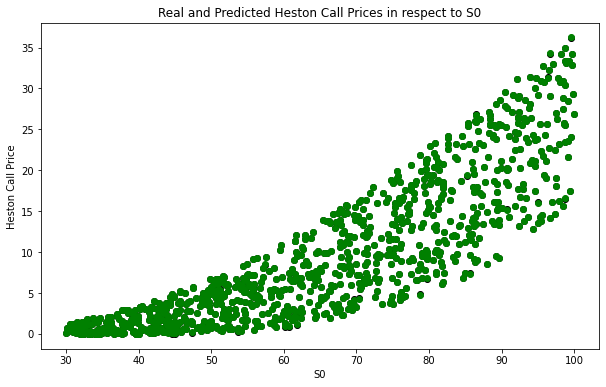

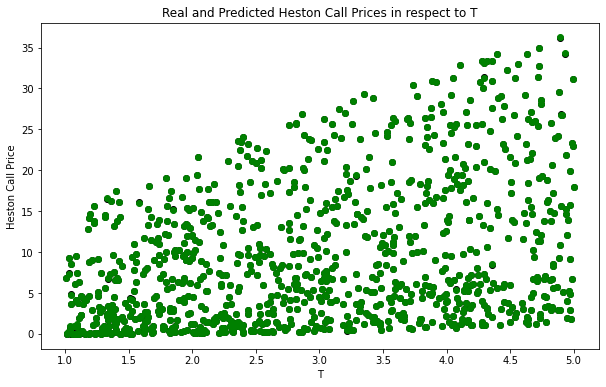

In [14]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            c=np.array(test_x[0,:,1].flatten())*5+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='hot')
plt.colorbar()
plt.scatter(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            c=np.array(test_x[0,:,1].flatten())*5+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='cool'
            )
plt.xlabel('S0')
plt.ylabel('Heston Call Price')
plt.title("Predicted and Real Heston Call Prices")
plt.colorbar()

# Predicted values
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            c=np.array(test_x[0,:,1].flatten())*5+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='hot')

plt.fill_between(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
                 lower[0,:,0].detach().numpy(), 
                 upper[0,:,0].detach().numpy(), 
                 color = 'grey', 
                 alpha=0.3)
plt.xlabel('S0')
plt.ylabel('Heston Call Price')
plt.title("Predicted Heston Call Prices with GPR")
plt.colorbar()

# Real Values 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            c=np.array(test_x[0,:,1].flatten())*5+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='cool'
            )
plt.xlabel('S0')
plt.ylabel('Heston Call Price')
plt.title("Real Heston Call Prices")
plt.colorbar()

# Comparaison respecting to S0
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            color="black")
plt.scatter(np.array(test_x[0,:,0].flatten())*100+(1-np.array(test_x[0,:,0].flatten()))*30, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            color="green")
plt.xlabel('S0')
plt.ylabel('Heston Call Price')
plt.title("Real and Predicted Heston Call Prices in respect to S0")

# Comparaison respecting to T
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,1].flatten())*5+(1-np.array(test_x[0,:,1].flatten()))*1, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            color="black")
plt.scatter(np.array(test_x[0,:,1].flatten())*5+(1-np.array(test_x[0,:,1].flatten()))*1, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            color="green")
plt.xlabel('T')
plt.ylabel('Heston Call Price')
plt.title("Real and Predicted Heston Call Prices in respect to T")

### Commentaires : 
On voit bien selon les graphes que pratiquement les valeurs prédites par gpr sont collées parfaitement avec les valeurs réelles. Ce qui montre que le modèle est bien précis. Mais ce modèle de gpr marche bien parce que les paramètres utilisées ne sont pas beaucoup (2 paramètres S0 et T).

# NN 

In [15]:
r=0.05
K=100
v0=0.1
kappa=2
theta=0.1
sigma=0.2
payoff="call"#call ou put
exercise="European"#european ou American

In [16]:
Heston_Call_Price = lambda s,t: HestonFormula(r,t,K,s, v0, kappa, theta, sigma, payoff, exercise)
training_number = 500   # Number of training samples
testing_number =  200  # Number of testing samples
# Les data d'entrainement et de teste pour le NN
train_s=torch.FloatTensor(np.random.uniform(30,100,training_number))
train_t=torch.FloatTensor(np.random.uniform(1,5,training_number))
test_s=torch.FloatTensor(np.random.uniform(70,150,testing_number))
test_t=torch.FloatTensor(np.random.uniform(1,5,testing_number))

# les listes de train_y et test_y (les prix évalués avec le modèle de Heston)
Heston_price_train=[Heston_Call_Price(np.array(train_s)[i], np.array(train_t)[i]) for i in range(training_number)]
Heston_price_test=[Heston_Call_Price(np.array(test_s)[i], np.array(test_t)[i]) for i in range(testing_number)]

train_x=torch.stack([train_s, train_t], -1)
test_x=torch.stack([test_s, test_t], -1)

train_y=torch.FloatTensor(np.array(Heston_price_train))
test_y=torch.FloatTensor(np.array(Heston_price_test))

In [17]:
# Construction de la dataframe qui contient toutes les données simulées
df = pd.DataFrame(np.array(train_x[:,0]))
df.columns=['Stock Price']
df['Strike Price']=K*np.ones(training_number)
df['Maturity']=np.array(train_x[:,1])
df['Dividends']=0*np.ones(training_number)
df['Volatility']=sigma*np.ones(training_number)
df['Risk-free']=r*np.ones(training_number)
df["Variance-Stock-Price"]=v0*np.ones(training_number)
df["kappa"]=kappa*np.ones(training_number)
df["theta"]=theta*np.ones(training_number)
df['Call Price']=np.array(train_y)


df['Stock Price'] = df['Stock Price']/df['Strike Price']
df['Call Price']  = df['Call Price'] /df['Strike Price']

df.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Variance-Stock-Price,kappa,theta,Call Price
0,0.666714,100.0,1.190645,0.0,0.2,0.05,0.1,2.0,0.1,0.022465
1,0.769997,100.0,2.750880,0.0,0.2,0.05,0.1,2.0,0.1,0.123099
2,0.490914,100.0,4.518661,0.0,0.2,0.05,0.1,2.0,0.1,0.055871
3,0.561717,100.0,1.602549,0.0,0.2,0.05,0.1,2.0,0.1,0.014779
4,0.740200,100.0,4.754817,0.0,0.2,0.05,0.1,2.0,0.1,0.182406


In [18]:
# Construction du modèle de NN
nodes = 100
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(nodes,  activation='relu', kernel_constraint=non_neg())) 
model.add(Dropout(0.25))
model.add(Dense(1 ,activation='elu', kernel_constraint=non_neg()))
model.compile(loss='mse',optimizer='rmsprop') 

# Entrainement du modèle 
history = model.fit(df.loc[:,['Stock Price', 'Maturity']], 
                    df['Call Price'], 
                    batch_size=64, 
                    epochs=500, 
                    validation_split=0.1, 
                    verbose=2)


Epoch 1/500
8/8 - 1s - loss: 1.7681 - val_loss: 1.4098 - 638ms/epoch - 80ms/step
Epoch 2/500
8/8 - 0s - loss: 1.3540 - val_loss: 0.9616 - 40ms/epoch - 5ms/step
Epoch 3/500
8/8 - 0s - loss: 0.9494 - val_loss: 0.7030 - 40ms/epoch - 5ms/step
Epoch 4/500
8/8 - 0s - loss: 0.7005 - val_loss: 0.4867 - 32ms/epoch - 4ms/step
Epoch 5/500
8/8 - 0s - loss: 0.4897 - val_loss: 0.3621 - 48ms/epoch - 6ms/step
Epoch 6/500
8/8 - 0s - loss: 0.3560 - val_loss: 0.2552 - 32ms/epoch - 4ms/step
Epoch 7/500
8/8 - 0s - loss: 0.2639 - val_loss: 0.1746 - 40ms/epoch - 5ms/step
Epoch 8/500
8/8 - 0s - loss: 0.1742 - val_loss: 0.1210 - 32ms/epoch - 4ms/step
Epoch 9/500
8/8 - 0s - loss: 0.1254 - val_loss: 0.0794 - 32ms/epoch - 4ms/step
Epoch 10/500
8/8 - 0s - loss: 0.0801 - val_loss: 0.0487 - 40ms/epoch - 5ms/step
Epoch 11/500
8/8 - 0s - loss: 0.0528 - val_loss: 0.0276 - 32ms/epoch - 4ms/step
Epoch 12/500
8/8 - 0s - loss: 0.0315 - val_loss: 0.0184 - 40ms/epoch - 5ms/step
Epoch 13/500
8/8 - 0s - loss: 0.0227 - val_loss

Epoch 99/500
8/8 - 0s - loss: 6.8946e-04 - val_loss: 1.6320e-04 - 40ms/epoch - 5ms/step
Epoch 100/500
8/8 - 0s - loss: 5.2507e-04 - val_loss: 1.5380e-04 - 32ms/epoch - 4ms/step
Epoch 101/500
8/8 - 0s - loss: 4.8265e-04 - val_loss: 1.6750e-04 - 40ms/epoch - 5ms/step
Epoch 102/500
8/8 - 0s - loss: 5.4739e-04 - val_loss: 3.6677e-04 - 40ms/epoch - 5ms/step
Epoch 103/500
8/8 - 0s - loss: 5.1445e-04 - val_loss: 0.0015 - 32ms/epoch - 4ms/step
Epoch 104/500
8/8 - 0s - loss: 6.2663e-04 - val_loss: 1.4024e-04 - 32ms/epoch - 4ms/step
Epoch 105/500
8/8 - 0s - loss: 3.7777e-04 - val_loss: 2.8003e-04 - 32ms/epoch - 4ms/step
Epoch 106/500
8/8 - 0s - loss: 4.8856e-04 - val_loss: 1.4603e-04 - 32ms/epoch - 4ms/step
Epoch 107/500
8/8 - 0s - loss: 4.5355e-04 - val_loss: 2.9986e-04 - 40ms/epoch - 5ms/step
Epoch 108/500
8/8 - 0s - loss: 5.5960e-04 - val_loss: 3.1185e-04 - 32ms/epoch - 4ms/step
Epoch 109/500
8/8 - 0s - loss: 4.2843e-04 - val_loss: 2.1491e-04 - 32ms/epoch - 4ms/step
Epoch 110/500
8/8 - 0s - l

Epoch 192/500
8/8 - 0s - loss: 3.4554e-04 - val_loss: 6.7759e-04 - 32ms/epoch - 4ms/step
Epoch 193/500
8/8 - 0s - loss: 3.6167e-04 - val_loss: 9.0321e-04 - 40ms/epoch - 5ms/step
Epoch 194/500
8/8 - 0s - loss: 4.3921e-04 - val_loss: 2.6050e-04 - 28ms/epoch - 4ms/step
Epoch 195/500
8/8 - 0s - loss: 3.2916e-04 - val_loss: 6.2327e-04 - 32ms/epoch - 4ms/step
Epoch 196/500
8/8 - 0s - loss: 3.4093e-04 - val_loss: 9.9276e-04 - 32ms/epoch - 4ms/step
Epoch 197/500
8/8 - 0s - loss: 3.4396e-04 - val_loss: 7.7639e-05 - 33ms/epoch - 4ms/step
Epoch 198/500
8/8 - 0s - loss: 2.4528e-04 - val_loss: 1.0312e-04 - 32ms/epoch - 4ms/step
Epoch 199/500
8/8 - 0s - loss: 3.4460e-04 - val_loss: 9.6795e-05 - 32ms/epoch - 4ms/step
Epoch 200/500
8/8 - 0s - loss: 3.3491e-04 - val_loss: 1.1053e-04 - 40ms/epoch - 5ms/step
Epoch 201/500
8/8 - 0s - loss: 3.3466e-04 - val_loss: 3.6248e-04 - 32ms/epoch - 4ms/step
Epoch 202/500
8/8 - 0s - loss: 3.7327e-04 - val_loss: 6.7597e-05 - 32ms/epoch - 4ms/step
Epoch 203/500
8/8 - 0

Epoch 285/500
8/8 - 0s - loss: 1.9142e-04 - val_loss: 2.5766e-04 - 40ms/epoch - 5ms/step
Epoch 286/500
8/8 - 0s - loss: 3.5586e-04 - val_loss: 1.9332e-04 - 32ms/epoch - 4ms/step
Epoch 287/500
8/8 - 0s - loss: 2.6523e-04 - val_loss: 2.5378e-04 - 41ms/epoch - 5ms/step
Epoch 288/500
8/8 - 0s - loss: 2.9750e-04 - val_loss: 6.8685e-04 - 32ms/epoch - 4ms/step
Epoch 289/500
8/8 - 0s - loss: 2.7108e-04 - val_loss: 9.7527e-05 - 32ms/epoch - 4ms/step
Epoch 290/500
8/8 - 0s - loss: 1.9049e-04 - val_loss: 0.0013 - 32ms/epoch - 4ms/step
Epoch 291/500
8/8 - 0s - loss: 3.5750e-04 - val_loss: 9.2584e-05 - 32ms/epoch - 4ms/step
Epoch 292/500
8/8 - 0s - loss: 2.5002e-04 - val_loss: 1.4439e-04 - 32ms/epoch - 4ms/step
Epoch 293/500
8/8 - 0s - loss: 2.6506e-04 - val_loss: 6.2555e-05 - 32ms/epoch - 4ms/step
Epoch 294/500
8/8 - 0s - loss: 2.0796e-04 - val_loss: 0.0011 - 32ms/epoch - 4ms/step
Epoch 295/500
8/8 - 0s - loss: 3.5298e-04 - val_loss: 1.5013e-04 - 32ms/epoch - 4ms/step
Epoch 296/500
8/8 - 0s - loss

Epoch 378/500
8/8 - 0s - loss: 2.9076e-04 - val_loss: 5.3468e-05 - 40ms/epoch - 5ms/step
Epoch 379/500
8/8 - 0s - loss: 1.8130e-04 - val_loss: 8.6768e-05 - 40ms/epoch - 5ms/step
Epoch 380/500
8/8 - 0s - loss: 3.0074e-04 - val_loss: 5.0909e-04 - 40ms/epoch - 5ms/step
Epoch 381/500
8/8 - 0s - loss: 2.3191e-04 - val_loss: 4.6448e-04 - 32ms/epoch - 4ms/step
Epoch 382/500
8/8 - 0s - loss: 2.6650e-04 - val_loss: 6.9150e-05 - 40ms/epoch - 5ms/step
Epoch 383/500
8/8 - 0s - loss: 1.8673e-04 - val_loss: 3.1662e-04 - 48ms/epoch - 6ms/step
Epoch 384/500
8/8 - 0s - loss: 2.8946e-04 - val_loss: 5.5724e-05 - 48ms/epoch - 6ms/step
Epoch 385/500
8/8 - 0s - loss: 2.0185e-04 - val_loss: 1.7759e-04 - 48ms/epoch - 6ms/step
Epoch 386/500
8/8 - 0s - loss: 2.4502e-04 - val_loss: 1.1977e-04 - 40ms/epoch - 5ms/step
Epoch 387/500
8/8 - 0s - loss: 1.6144e-04 - val_loss: 2.9155e-04 - 40ms/epoch - 5ms/step
Epoch 388/500
8/8 - 0s - loss: 2.2926e-04 - val_loss: 7.5123e-05 - 40ms/epoch - 5ms/step
Epoch 389/500
8/8 - 0

Epoch 471/500
8/8 - 0s - loss: 3.0793e-04 - val_loss: 3.4219e-04 - 40ms/epoch - 5ms/step
Epoch 472/500
8/8 - 0s - loss: 1.8247e-04 - val_loss: 5.3748e-04 - 40ms/epoch - 5ms/step
Epoch 473/500
8/8 - 0s - loss: 2.5506e-04 - val_loss: 4.7644e-04 - 40ms/epoch - 5ms/step
Epoch 474/500
8/8 - 0s - loss: 2.1734e-04 - val_loss: 2.1569e-04 - 40ms/epoch - 5ms/step
Epoch 475/500
8/8 - 0s - loss: 1.8980e-04 - val_loss: 4.4636e-04 - 32ms/epoch - 4ms/step
Epoch 476/500
8/8 - 0s - loss: 2.5851e-04 - val_loss: 5.8090e-04 - 32ms/epoch - 4ms/step
Epoch 477/500
8/8 - 0s - loss: 2.8353e-04 - val_loss: 7.3947e-05 - 32ms/epoch - 4ms/step
Epoch 478/500
8/8 - 0s - loss: 1.8692e-04 - val_loss: 9.3131e-05 - 32ms/epoch - 4ms/step
Epoch 479/500
8/8 - 0s - loss: 1.5830e-04 - val_loss: 8.2293e-04 - 40ms/epoch - 5ms/step
Epoch 480/500
8/8 - 0s - loss: 3.4365e-04 - val_loss: 5.6353e-04 - 40ms/epoch - 5ms/step
Epoch 481/500
8/8 - 0s - loss: 2.2882e-04 - val_loss: 4.6725e-04 - 40ms/epoch - 5ms/step
Epoch 482/500
8/8 - 0

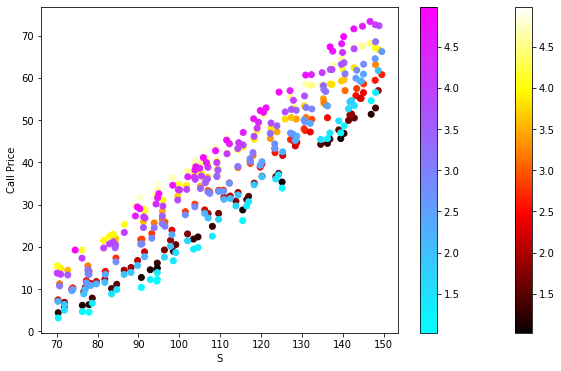

In [132]:
# Evaluation du modèle 
test=np.array(test_x)[:]
test[:,0]=test[:,0]/K
y_hat = model.predict(np.array(test))*K

# Plotter les figures de valuers réelles et prédites avec le modèle de NN
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[:,0]), y_hat, label = 'NN Prediction',c=np.array(test_x[:,1]),cmap='hot')
plt.colorbar()
plt.scatter(np.array(test_x[:,0]), np.array(test_y),c=np.array(test_x[:,1]),cmap='cool', label = 'Analytical Model')
plt.xlabel('S')
plt.ylabel('Call Price')
plt.colorbar()

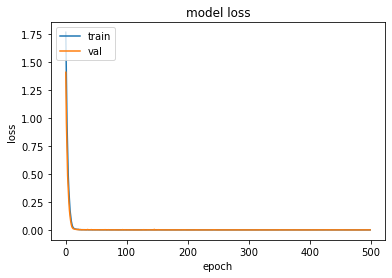

In [19]:
# Plotter la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Commentaire :
On remarque que la prédiction est moins précis que le modèle de GPR. Mais au niveau au niveau de Loss pour le train et le val est très petite et il n'y a pas une grande différence ce qui évite les problèmes d'overfitting et overfitting.

# Question2

 Dans cette exercice on crée des modèles de NN pour la calibration des paramètres sigma, v0, kappa et theta à partir des prix synthétiques construites en changeant les strikes k entre 70 et 200 en distinguant 3 cas suivants :

## Callibrer sigma et fixer v0, kappa et theta

In [21]:
# Paramètres initiales 
r=0.05
T=1
S0=100
v0=0.1
kappa=2
theta=0.1
sigma=0.2
payoff="call"#call ou put
exercise="European"#european ou American

In [22]:
# Créer les prix synthétiques
Heston_Call_Price = lambda K: HestonFormula(r,T,K,S0, v0, kappa, theta, sigma, payoff, exercise)
N=1000# nombre de prix synthétiques

train_k=torch.FloatTensor(np.random.uniform(70,200,N))
synthetic_prices=[Heston_Call_Price(np.array(train_k)[i]) for i in range(N)]

# Créer la dataframe pour regrouper les données
df = pd.DataFrame(synthetic_prices)
df.columns=['Synthetic Prices']
df['Strike']=np.array(train_k)

df.head()

,Synthetic Prices,Strike
0,2.371768,150.957047
1,24.335911,83.538818
2,20.093099,90.146584
3,0.986941,173.894913
4,0.404968,197.305389


In [23]:
# Une fonction pour callibrer les sigma 
def sigma_minimize(price, r,T,K,S0, v0, kappa, theta, payoff, exercise, disp=False):
    """ Returns Implied volatility by minimization"""
    
    n = 2     
    def obj_fun(sigma):
        return ( HestonFormula(r,T,K,S0, v0, kappa, theta, sigma, payoff, exercise)-price)**n
        
    res = scpo.minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return 0.2

In [24]:
# Calculer les sigma résultantes à partir de sprix synthétiques en utulisant la fonction précédente
sigma_data = df.apply(lambda x: sigma_minimize(x['Synthetic Prices'], 
                                         r, T, x['Strike'], 
                                         S0, v0,kappa, theta, 
                                         payoff, exercise,
                                         disp=False), axis=1)
# Rajouter les valeurs de sigma au dataframe (600 nombre de test samples et 400 le nombre de train)
df["sigma"]=sigma_data.values
df_test=df.iloc[:600]
df_train=df.iloc[600:]

In [27]:
# Construire un modèle de NN
nodes = 100
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(nodes,  activation='relu', kernel_constraint=non_neg())) 
model.add(Dropout(0.25))
model.add(Dense(1 ,activation='relu', kernel_constraint=non_neg())) 
model.compile(loss='mse',optimizer='rmsprop') 

# Entrainer le modèle de NN avec les données calibrées
history = model.fit(df_train.loc[:,['Strike', 'Synthetic Prices']], df_train['sigma'], batch_size=64, epochs=500, validation_split=0.1, verbose=2)

Epoch 1/500
6/6 - 0s - loss: 2978.2629 - val_loss: 2713.1448 - 494ms/epoch - 82ms/step
Epoch 2/500
6/6 - 0s - loss: 2564.3213 - val_loss: 2133.3003 - 40ms/epoch - 7ms/step
Epoch 3/500
6/6 - 0s - loss: 2035.8190 - val_loss: 1740.2875 - 32ms/epoch - 5ms/step
Epoch 4/500
6/6 - 0s - loss: 1714.5067 - val_loss: 1422.0878 - 32ms/epoch - 5ms/step
Epoch 5/500
6/6 - 0s - loss: 1378.3142 - val_loss: 1170.0330 - 32ms/epoch - 5ms/step
Epoch 6/500
6/6 - 0s - loss: 1091.8060 - val_loss: 962.4396 - 32ms/epoch - 5ms/step
Epoch 7/500
6/6 - 0s - loss: 881.8884 - val_loss: 796.9327 - 32ms/epoch - 5ms/step
Epoch 8/500
6/6 - 0s - loss: 769.6933 - val_loss: 648.4501 - 32ms/epoch - 5ms/step
Epoch 9/500
6/6 - 0s - loss: 624.3524 - val_loss: 525.0533 - 32ms/epoch - 5ms/step
Epoch 10/500
6/6 - 0s - loss: 515.1890 - val_loss: 420.6380 - 32ms/epoch - 5ms/step
Epoch 11/500
6/6 - 0s - loss: 404.8232 - val_loss: 336.6329 - 32ms/epoch - 5ms/step
Epoch 12/500
6/6 - 0s - loss: 315.0500 - val_loss: 266.8803 - 40ms/epoch

Epoch 103/500
6/6 - 0s - loss: 7.2811 - val_loss: 6.2686 - 40ms/epoch - 7ms/step
Epoch 104/500
6/6 - 0s - loss: 7.6901 - val_loss: 6.2966 - 32ms/epoch - 5ms/step
Epoch 105/500
6/6 - 0s - loss: 6.9670 - val_loss: 6.2524 - 32ms/epoch - 5ms/step
Epoch 106/500
6/6 - 0s - loss: 7.0450 - val_loss: 6.4168 - 32ms/epoch - 5ms/step
Epoch 107/500
6/6 - 0s - loss: 7.2557 - val_loss: 6.5406 - 32ms/epoch - 5ms/step
Epoch 108/500
6/6 - 0s - loss: 7.3761 - val_loss: 6.2188 - 32ms/epoch - 5ms/step
Epoch 109/500
6/6 - 0s - loss: 7.3843 - val_loss: 6.5417 - 32ms/epoch - 5ms/step
Epoch 110/500
6/6 - 0s - loss: 6.9397 - val_loss: 6.1941 - 65ms/epoch - 11ms/step
Epoch 111/500
6/6 - 0s - loss: 7.1286 - val_loss: 6.2005 - 72ms/epoch - 12ms/step
Epoch 112/500
6/6 - 0s - loss: 6.8872 - val_loss: 6.1885 - 72ms/epoch - 12ms/step
Epoch 113/500
6/6 - 0s - loss: 6.9624 - val_loss: 6.1555 - 80ms/epoch - 13ms/step
Epoch 114/500
6/6 - 0s - loss: 7.2767 - val_loss: 6.1544 - 32ms/epoch - 5ms/step
Epoch 115/500
6/6 - 0s -

6/6 - 0s - loss: 5.3500 - val_loss: 5.1336 - 32ms/epoch - 5ms/step
Epoch 205/500
6/6 - 0s - loss: 5.8850 - val_loss: 4.5661 - 40ms/epoch - 7ms/step
Epoch 206/500
6/6 - 0s - loss: 5.3973 - val_loss: 4.4989 - 40ms/epoch - 7ms/step
Epoch 207/500
6/6 - 0s - loss: 5.2073 - val_loss: 4.4354 - 40ms/epoch - 7ms/step
Epoch 208/500
6/6 - 0s - loss: 5.5523 - val_loss: 4.3994 - 32ms/epoch - 5ms/step
Epoch 209/500
6/6 - 0s - loss: 5.3475 - val_loss: 4.4746 - 32ms/epoch - 5ms/step
Epoch 210/500
6/6 - 0s - loss: 5.6409 - val_loss: 4.3436 - 32ms/epoch - 5ms/step
Epoch 211/500
6/6 - 0s - loss: 5.2916 - val_loss: 4.3116 - 48ms/epoch - 8ms/step
Epoch 212/500
6/6 - 0s - loss: 5.6453 - val_loss: 4.3264 - 40ms/epoch - 7ms/step
Epoch 213/500
6/6 - 0s - loss: 5.1826 - val_loss: 4.4345 - 40ms/epoch - 7ms/step
Epoch 214/500
6/6 - 0s - loss: 5.1681 - val_loss: 4.2997 - 40ms/epoch - 7ms/step
Epoch 215/500
6/6 - 0s - loss: 5.3283 - val_loss: 4.2253 - 40ms/epoch - 7ms/step
Epoch 216/500
6/6 - 0s - loss: 5.1093 - va

Epoch 306/500
6/6 - 0s - loss: 3.4920 - val_loss: 3.1579 - 32ms/epoch - 5ms/step
Epoch 307/500
6/6 - 0s - loss: 3.8138 - val_loss: 2.5890 - 32ms/epoch - 5ms/step
Epoch 308/500
6/6 - 0s - loss: 3.6531 - val_loss: 2.2948 - 32ms/epoch - 5ms/step
Epoch 309/500
6/6 - 0s - loss: 3.3398 - val_loss: 2.3036 - 40ms/epoch - 7ms/step
Epoch 310/500
6/6 - 0s - loss: 3.3110 - val_loss: 2.3103 - 40ms/epoch - 7ms/step
Epoch 311/500
6/6 - 0s - loss: 3.1355 - val_loss: 2.3358 - 32ms/epoch - 5ms/step
Epoch 312/500
6/6 - 0s - loss: 3.6857 - val_loss: 2.3848 - 32ms/epoch - 5ms/step
Epoch 313/500
6/6 - 0s - loss: 3.0477 - val_loss: 2.9779 - 40ms/epoch - 7ms/step
Epoch 314/500
6/6 - 0s - loss: 3.7389 - val_loss: 2.2144 - 40ms/epoch - 7ms/step
Epoch 315/500
6/6 - 0s - loss: 3.5119 - val_loss: 2.3165 - 32ms/epoch - 5ms/step
Epoch 316/500
6/6 - 0s - loss: 3.6513 - val_loss: 2.3241 - 40ms/epoch - 7ms/step
Epoch 317/500
6/6 - 0s - loss: 3.2977 - val_loss: 2.3016 - 32ms/epoch - 5ms/step
Epoch 318/500
6/6 - 0s - los

Epoch 407/500
6/6 - 0s - loss: 2.4355 - val_loss: 1.4655 - 32ms/epoch - 5ms/step
Epoch 408/500
6/6 - 0s - loss: 2.5850 - val_loss: 1.5998 - 32ms/epoch - 5ms/step
Epoch 409/500
6/6 - 0s - loss: 2.0485 - val_loss: 1.5351 - 40ms/epoch - 7ms/step
Epoch 410/500
6/6 - 0s - loss: 2.6472 - val_loss: 2.2651 - 40ms/epoch - 7ms/step
Epoch 411/500
6/6 - 0s - loss: 2.7084 - val_loss: 1.4013 - 40ms/epoch - 7ms/step
Epoch 412/500
6/6 - 0s - loss: 2.6568 - val_loss: 1.3378 - 48ms/epoch - 8ms/step
Epoch 413/500
6/6 - 0s - loss: 2.2704 - val_loss: 1.4119 - 40ms/epoch - 7ms/step
Epoch 414/500
6/6 - 0s - loss: 2.4142 - val_loss: 1.4658 - 40ms/epoch - 7ms/step
Epoch 415/500
6/6 - 0s - loss: 2.6100 - val_loss: 1.4827 - 40ms/epoch - 7ms/step
Epoch 416/500
6/6 - 0s - loss: 2.5421 - val_loss: 2.3917 - 32ms/epoch - 5ms/step
Epoch 417/500
6/6 - 0s - loss: 2.4472 - val_loss: 1.3247 - 40ms/epoch - 7ms/step
Epoch 418/500
6/6 - 0s - loss: 2.9631 - val_loss: 1.9774 - 40ms/epoch - 7ms/step
Epoch 419/500
6/6 - 0s - los

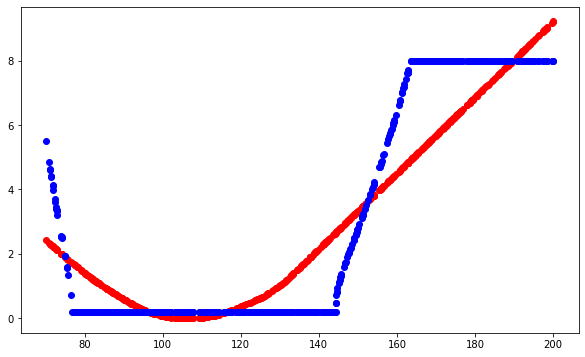

In [28]:
# Evaluer le modèle et plotter les résultats 
y_hat = model.predict(df_test.loc[:,['Strike', 'Synthetic Prices']])
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], np.array(y_hat), label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['sigma'], label = 'sigma',color='b')

### Commentaire :
On voit bien qu'il y'a des résultats moins précis. Cela revient au fait que la fonction qui minimise la prédiction est approximative et ne donne pas de bonnes résultats.

## calibrer sigma et theta et fixer kappa et v0

In [29]:
# fonction pour trouver sigma et theta qui minimise la différence avec un prix synthétique
def sigma_theta_minimize(price, r,T,K,S0, v0, kappa, payoff, exercise, disp=False):
    """ Returns Implied volatility by minimization"""
    n = 2     
    def obj_fun(a=[theta,sigma]):
        return ( HestonFormula(r,T,K,S0, v0, kappa, a[0], a[1], payoff, exercise)-price)**n
    initial_guess=[0.2,0.1]  
    bnds = ((0, None), (0, None))
    res = scpo.minimize(obj_fun, initial_guess, method='SLSQP', bounds=bnds)
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return [0.2, 0.1]

In [30]:
# Construire les données de theta et de sigma callibrées à partir des prix synthétiques en utulisant la fonction précédente
thetas=[]
sigmas=[]
for i in range(N):
    x=sigma_theta_minimize(df['Synthetic Prices'][i], r,T,df["Strike"][i],S0, v0, kappa, payoff, exercise, disp=False)
    thetas.append(x[0])
    sigmas.append(x[1])

In [31]:
# Rajouter les valeurs de sigma et theta au dataframe
df["sigma"]=sigmas
df["theta"]=thetas
df_test=df.iloc[:600]
df_train=df.iloc[600:]
df.head()

,Synthetic Prices,Strike,sigma,theta
0,2.371768,150.957047,0.247321,0.099749
1,24.335911,83.538818,0.456773,0.103075
2,20.093099,90.146584,0.956311,0.120880
3,0.986941,173.894913,0.049002,0.102293
4,0.404968,197.305389,0.043593,0.104450


In [32]:
# Construire le modèle de NN 
nodes = 100
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(nodes,  activation='relu', kernel_constraint=non_neg())) 
model.add(Dropout(0.25))
model.add(Dense(2 ,activation='relu', kernel_constraint=non_neg()))
model.compile(loss='mse',optimizer='rmsprop') 

# Entrainer le modèle de NN avec les données 
history = model.fit(df_train.loc[:,['Strike', 'Synthetic Prices']], df_train[['sigma', "theta"]], batch_size=64, epochs=500, validation_split=0.1, verbose=2)


Epoch 1/500
6/6 - 0s - loss: 850.1760 - val_loss: 799.2592 - 369ms/epoch - 62ms/step
Epoch 2/500
6/6 - 0s - loss: 750.3571 - val_loss: 602.6594 - 29ms/epoch - 5ms/step
Epoch 3/500
6/6 - 0s - loss: 577.9919 - val_loss: 480.1424 - 26ms/epoch - 4ms/step
Epoch 4/500
6/6 - 0s - loss: 469.2370 - val_loss: 387.1491 - 28ms/epoch - 5ms/step
Epoch 5/500
6/6 - 0s - loss: 381.2940 - val_loss: 315.1584 - 30ms/epoch - 5ms/step
Epoch 6/500
6/6 - 0s - loss: 299.1340 - val_loss: 259.8474 - 30ms/epoch - 5ms/step
Epoch 7/500
6/6 - 0s - loss: 255.0751 - val_loss: 214.5289 - 29ms/epoch - 5ms/step
Epoch 8/500
6/6 - 0s - loss: 210.2958 - val_loss: 175.8357 - 26ms/epoch - 4ms/step
Epoch 9/500
6/6 - 0s - loss: 173.4053 - val_loss: 142.6716 - 29ms/epoch - 5ms/step
Epoch 10/500
6/6 - 0s - loss: 139.2218 - val_loss: 116.2711 - 28ms/epoch - 5ms/step
Epoch 11/500
6/6 - 0s - loss: 116.1295 - val_loss: 94.4996 - 26ms/epoch - 4ms/step
Epoch 12/500
6/6 - 0s - loss: 92.4981 - val_loss: 76.2630 - 30ms/epoch - 5ms/step
Ep

Epoch 103/500
6/6 - 0s - loss: 0.1144 - val_loss: 0.1213 - 28ms/epoch - 5ms/step
Epoch 104/500
6/6 - 0s - loss: 0.1280 - val_loss: 0.1272 - 25ms/epoch - 4ms/step
Epoch 105/500
6/6 - 0s - loss: 0.1191 - val_loss: 0.1194 - 28ms/epoch - 5ms/step
Epoch 106/500
6/6 - 0s - loss: 0.1223 - val_loss: 0.1206 - 29ms/epoch - 5ms/step
Epoch 107/500
6/6 - 0s - loss: 0.1202 - val_loss: 0.1240 - 44ms/epoch - 7ms/step
Epoch 108/500
6/6 - 0s - loss: 0.1209 - val_loss: 0.1192 - 42ms/epoch - 7ms/step
Epoch 109/500
6/6 - 0s - loss: 0.1211 - val_loss: 0.1182 - 38ms/epoch - 6ms/step
Epoch 110/500
6/6 - 0s - loss: 0.1207 - val_loss: 0.1188 - 24ms/epoch - 4ms/step
Epoch 111/500
6/6 - 0s - loss: 0.1218 - val_loss: 0.1299 - 33ms/epoch - 5ms/step
Epoch 112/500
6/6 - 0s - loss: 0.1181 - val_loss: 0.1179 - 29ms/epoch - 5ms/step
Epoch 113/500
6/6 - 0s - loss: 0.1155 - val_loss: 0.1186 - 43ms/epoch - 7ms/step
Epoch 114/500
6/6 - 0s - loss: 0.1154 - val_loss: 0.1243 - 37ms/epoch - 6ms/step
Epoch 115/500
6/6 - 0s - los

6/6 - 0s - loss: 0.1084 - val_loss: 0.1075 - 16ms/epoch - 3ms/step
Epoch 205/500
6/6 - 0s - loss: 0.1042 - val_loss: 0.1061 - 31ms/epoch - 5ms/step
Epoch 206/500
6/6 - 0s - loss: 0.1065 - val_loss: 0.1058 - 31ms/epoch - 5ms/step
Epoch 207/500
6/6 - 0s - loss: 0.1081 - val_loss: 0.1063 - 16ms/epoch - 3ms/step
Epoch 208/500
6/6 - 0s - loss: 0.1065 - val_loss: 0.1067 - 42ms/epoch - 7ms/step
Epoch 209/500
6/6 - 0s - loss: 0.1072 - val_loss: 0.1052 - 13ms/epoch - 2ms/step
Epoch 210/500
6/6 - 0s - loss: 0.1050 - val_loss: 0.1086 - 16ms/epoch - 3ms/step
Epoch 211/500
6/6 - 0s - loss: 0.1036 - val_loss: 0.1050 - 32ms/epoch - 5ms/step
Epoch 212/500
6/6 - 0s - loss: 0.1068 - val_loss: 0.1090 - 31ms/epoch - 5ms/step
Epoch 213/500
6/6 - 0s - loss: 0.1052 - val_loss: 0.1045 - 31ms/epoch - 5ms/step
Epoch 214/500
6/6 - 0s - loss: 0.1050 - val_loss: 0.1075 - 31ms/epoch - 5ms/step
Epoch 215/500
6/6 - 0s - loss: 0.1042 - val_loss: 0.1116 - 16ms/epoch - 3ms/step
Epoch 216/500
6/6 - 0s - loss: 0.1041 - va

Epoch 306/500
6/6 - 0s - loss: 0.1025 - val_loss: 0.1025 - 31ms/epoch - 5ms/step
Epoch 307/500
6/6 - 0s - loss: 0.1031 - val_loss: 0.1063 - 22ms/epoch - 4ms/step
Epoch 308/500
6/6 - 0s - loss: 0.1054 - val_loss: 0.1033 - 31ms/epoch - 5ms/step
Epoch 309/500
6/6 - 0s - loss: 0.1022 - val_loss: 0.1034 - 31ms/epoch - 5ms/step
Epoch 310/500
6/6 - 0s - loss: 0.1029 - val_loss: 0.1028 - 16ms/epoch - 3ms/step
Epoch 311/500
6/6 - 0s - loss: 0.1023 - val_loss: 0.1037 - 31ms/epoch - 5ms/step
Epoch 312/500
6/6 - 0s - loss: 0.1033 - val_loss: 0.1039 - 31ms/epoch - 5ms/step
Epoch 313/500
6/6 - 0s - loss: 0.1030 - val_loss: 0.1030 - 40ms/epoch - 7ms/step
Epoch 314/500
6/6 - 0s - loss: 0.1029 - val_loss: 0.1040 - 35ms/epoch - 6ms/step
Epoch 315/500
6/6 - 0s - loss: 0.1024 - val_loss: 0.1133 - 26ms/epoch - 4ms/step
Epoch 316/500
6/6 - 0s - loss: 0.1055 - val_loss: 0.1043 - 28ms/epoch - 5ms/step
Epoch 317/500
6/6 - 0s - loss: 0.1050 - val_loss: 0.1041 - 26ms/epoch - 4ms/step
Epoch 318/500
6/6 - 0s - los

6/6 - 0s - loss: 0.1039 - val_loss: 0.1016 - 32ms/epoch - 5ms/step
Epoch 408/500
6/6 - 0s - loss: 0.1023 - val_loss: 0.1030 - 31ms/epoch - 5ms/step
Epoch 409/500
6/6 - 0s - loss: 0.1012 - val_loss: 0.1044 - 31ms/epoch - 5ms/step
Epoch 410/500
6/6 - 0s - loss: 0.1043 - val_loss: 0.1025 - 29ms/epoch - 5ms/step
Epoch 411/500
6/6 - 0s - loss: 0.1017 - val_loss: 0.1023 - 30ms/epoch - 5ms/step
Epoch 412/500
6/6 - 0s - loss: 0.1042 - val_loss: 0.1033 - 33ms/epoch - 6ms/step
Epoch 413/500
6/6 - 0s - loss: 0.1037 - val_loss: 0.1048 - 31ms/epoch - 5ms/step
Epoch 414/500
6/6 - 0s - loss: 0.1045 - val_loss: 0.1023 - 36ms/epoch - 6ms/step
Epoch 415/500
6/6 - 0s - loss: 0.1015 - val_loss: 0.1054 - 24ms/epoch - 4ms/step
Epoch 416/500
6/6 - 0s - loss: 0.1048 - val_loss: 0.1041 - 28ms/epoch - 5ms/step
Epoch 417/500
6/6 - 0s - loss: 0.1022 - val_loss: 0.1018 - 33ms/epoch - 6ms/step
Epoch 418/500
6/6 - 0s - loss: 0.1016 - val_loss: 0.1042 - 31ms/epoch - 5ms/step
Epoch 419/500
6/6 - 0s - loss: 0.1046 - va

Text(0.5, 1.0, 'Prediction for theta')

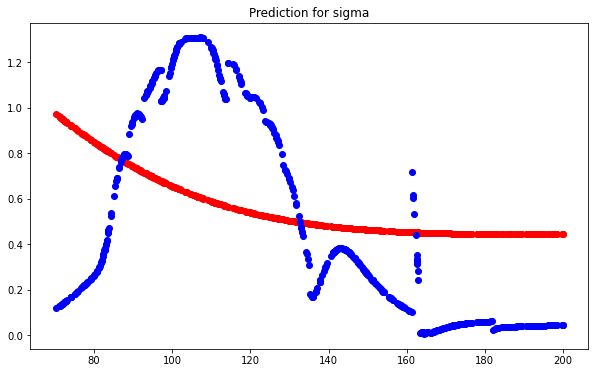

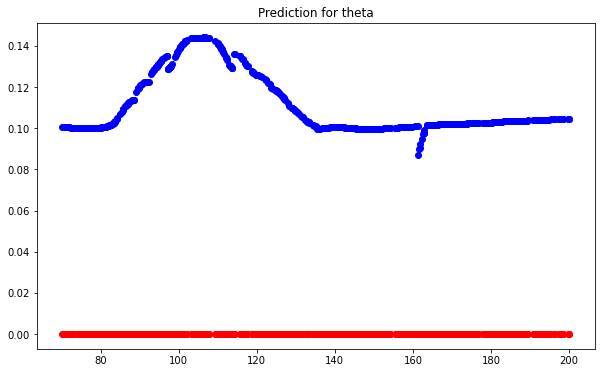

In [33]:
# Evaluer et plotter les résultats 
y_hat = model.predict(df_test.loc[:,['Strike', 'Synthetic Prices']])
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], y_hat[:,0], label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['sigma'], label = 'sigma',color='b')
plt.title("Prediction for sigma")

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], y_hat[:,1], label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['theta'], label = 'sigma',color='b')
plt.title("Prediction for theta")

### Commentaire : 
On voit que les résultats obtenus sont plus pires pour les deux paramètres (sigma et theta) comparant avec le premier cas. Cela revient au problème des données qui sont moins précis et qui ont été alimentés au modèle parce que la minimisation est moins précis et il y'a une multivariété des paramètres à équilibrer.

### Callibrer sigma, theta, kappa et v0

In [34]:
# Fonction pour trouver les paramètres (sigma, theta, kappa et v0) qui minimsent la différence
def all_minimize(price, r,T,K,S0, v0, kappa, payoff, exercise, disp=False):
    """ Returns Implied volatility by minimization"""
    
    n = 2     
    def obj_fun(a=[sigma, theta, kappa, v0]):
        return ( HestonFormula(r,T,K,S0, a[3], a[2], a[1], a[0], payoff, exercise)-price)**n
    initial_guess=[0.01,0.01, 2, 0.01]  
    bnds = ((0, None), (0, None), (0, None), (0, None))
    res = scpo.minimize(obj_fun, initial_guess, method='SLSQP', bounds=bnds)
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return [0.2,0.1,2,0.1]

In [35]:
# Construire les valeurs calibrées à partir des prix pour les utuliser aux données
Sigma=[]
Theta=[]
Kappa=[]
V_0=[]
for i in range(N):
    x=all_minimize(df['Synthetic Prices'][i], r,T,df["Strike"][i],S0, v0, kappa, payoff, exercise, disp=False)
    Sigma.append(x[0])
    Theta.append(x[1])
    Kappa.append(x[2])
    V_0.append(x[3])

In [36]:
# Rajouter les valeurs au dataframe
df["sigma"]=Sigma
df["theta"]=Theta
df["kappa"]=Kappa
df["v0"]=V_0
df_test=df.iloc[:600]
df_train=df.iloc[600:]
df.head()

,Synthetic Prices,Strike,sigma,theta,kappa,v0
0,2.371768,150.957047,0.010859,0.110588,2.000136,0.086722
1,24.335911,83.538818,0.049703,0.118533,1.930439,0.075709
2,20.093099,90.146584,0.309413,0.117009,1.342676,0.089058
3,0.986941,173.894913,0.014680,0.117587,2.005543,0.080022
4,0.404968,197.305389,0.010000,0.010000,2.000000,0.010000


In [37]:
# La construction du modèle de NN
nodes = 100
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(nodes,  activation='relu', kernel_constraint=non_neg())) 
model.add(Dropout(0.25))
model.add(Dense(4 ,activation='relu', kernel_constraint=non_neg()))
model.compile(loss='mse',optimizer='rmsprop') 

# L'entrainement du modèl avec les données 
history = model.fit(df_train.loc[:,['Strike', 'Synthetic Prices']], df_train[['sigma', "theta", "kappa","v0"]], batch_size=64, epochs=500, validation_split=0.1, verbose=2)


Epoch 1/500
6/6 - 0s - loss: 1485.3245 - val_loss: 1433.7692 - 377ms/epoch - 63ms/step
Epoch 2/500
6/6 - 0s - loss: 1329.6165 - val_loss: 1103.7610 - 31ms/epoch - 5ms/step
Epoch 3/500
6/6 - 0s - loss: 1043.9944 - val_loss: 886.0018 - 32ms/epoch - 5ms/step
Epoch 4/500
6/6 - 0s - loss: 833.5432 - val_loss: 722.1687 - 31ms/epoch - 5ms/step
Epoch 5/500
6/6 - 0s - loss: 689.6218 - val_loss: 591.5842 - 31ms/epoch - 5ms/step
Epoch 6/500
6/6 - 0s - loss: 573.7065 - val_loss: 482.6122 - 31ms/epoch - 5ms/step
Epoch 7/500
6/6 - 0s - loss: 475.9990 - val_loss: 390.6673 - 32ms/epoch - 5ms/step
Epoch 8/500
6/6 - 0s - loss: 373.5645 - val_loss: 318.7366 - 16ms/epoch - 3ms/step
Epoch 9/500
6/6 - 0s - loss: 310.3377 - val_loss: 259.6421 - 31ms/epoch - 5ms/step
Epoch 10/500
6/6 - 0s - loss: 251.2450 - val_loss: 210.5472 - 32ms/epoch - 5ms/step
Epoch 11/500
6/6 - 0s - loss: 202.4289 - val_loss: 170.7431 - 16ms/epoch - 3ms/step
Epoch 12/500
6/6 - 0s - loss: 165.0452 - val_loss: 137.5505 - 31ms/epoch - 5ms

Epoch 103/500
6/6 - 0s - loss: 0.1074 - val_loss: 0.1139 - 32ms/epoch - 5ms/step
Epoch 104/500
6/6 - 0s - loss: 0.1105 - val_loss: 0.1327 - 31ms/epoch - 5ms/step
Epoch 105/500
6/6 - 0s - loss: 0.1338 - val_loss: 0.1186 - 31ms/epoch - 5ms/step
Epoch 106/500
6/6 - 0s - loss: 0.1104 - val_loss: 0.1157 - 27ms/epoch - 5ms/step
Epoch 107/500
6/6 - 0s - loss: 0.1097 - val_loss: 0.1455 - 20ms/epoch - 3ms/step
Epoch 108/500
6/6 - 0s - loss: 0.1283 - val_loss: 0.1310 - 31ms/epoch - 5ms/step
Epoch 109/500
6/6 - 0s - loss: 0.1134 - val_loss: 0.1278 - 16ms/epoch - 3ms/step
Epoch 110/500
6/6 - 0s - loss: 0.1177 - val_loss: 0.1502 - 33ms/epoch - 6ms/step
Epoch 111/500
6/6 - 0s - loss: 0.1118 - val_loss: 0.1188 - 30ms/epoch - 5ms/step
Epoch 112/500
6/6 - 0s - loss: 0.1156 - val_loss: 0.1217 - 16ms/epoch - 3ms/step
Epoch 113/500
6/6 - 0s - loss: 0.1098 - val_loss: 0.1223 - 31ms/epoch - 5ms/step
Epoch 114/500
6/6 - 0s - loss: 0.1131 - val_loss: 0.1119 - 32ms/epoch - 5ms/step
Epoch 115/500
6/6 - 0s - los

6/6 - 0s - loss: 0.1042 - val_loss: 0.1065 - 20ms/epoch - 3ms/step
Epoch 205/500
6/6 - 0s - loss: 0.1048 - val_loss: 0.1075 - 31ms/epoch - 5ms/step
Epoch 206/500
6/6 - 0s - loss: 0.1016 - val_loss: 0.1103 - 31ms/epoch - 5ms/step
Epoch 207/500
6/6 - 0s - loss: 0.1024 - val_loss: 0.1078 - 18ms/epoch - 3ms/step
Epoch 208/500
6/6 - 0s - loss: 0.0999 - val_loss: 0.1094 - 30ms/epoch - 5ms/step
Epoch 209/500
6/6 - 0s - loss: 0.1087 - val_loss: 0.1174 - 31ms/epoch - 5ms/step
Epoch 210/500
6/6 - 0s - loss: 0.0979 - val_loss: 0.1081 - 16ms/epoch - 3ms/step
Epoch 211/500
6/6 - 0s - loss: 0.1036 - val_loss: 0.1098 - 32ms/epoch - 5ms/step
Epoch 212/500
6/6 - 0s - loss: 0.1010 - val_loss: 0.1077 - 31ms/epoch - 5ms/step
Epoch 213/500
6/6 - 0s - loss: 0.1102 - val_loss: 0.1095 - 16ms/epoch - 3ms/step
Epoch 214/500
6/6 - 0s - loss: 0.1093 - val_loss: 0.1090 - 16ms/epoch - 3ms/step
Epoch 215/500
6/6 - 0s - loss: 0.0980 - val_loss: 0.1075 - 32ms/epoch - 5ms/step
Epoch 216/500
6/6 - 0s - loss: 0.0983 - va

Epoch 306/500
6/6 - 0s - loss: 0.0986 - val_loss: 0.1113 - 31ms/epoch - 5ms/step
Epoch 307/500
6/6 - 0s - loss: 0.1031 - val_loss: 0.1127 - 31ms/epoch - 5ms/step
Epoch 308/500
6/6 - 0s - loss: 0.0959 - val_loss: 0.1046 - 26ms/epoch - 4ms/step
Epoch 309/500
6/6 - 0s - loss: 0.1000 - val_loss: 0.1198 - 12ms/epoch - 2ms/step
Epoch 310/500
6/6 - 0s - loss: 0.0989 - val_loss: 0.1091 - 31ms/epoch - 5ms/step
Epoch 311/500
6/6 - 0s - loss: 0.1001 - val_loss: 0.1073 - 31ms/epoch - 5ms/step
Epoch 312/500
6/6 - 0s - loss: 0.0981 - val_loss: 0.1020 - 30ms/epoch - 5ms/step
Epoch 313/500
6/6 - 0s - loss: 0.1019 - val_loss: 0.1240 - 15ms/epoch - 2ms/step
Epoch 314/500
6/6 - 0s - loss: 0.0995 - val_loss: 0.1097 - 39ms/epoch - 7ms/step
Epoch 315/500
6/6 - 0s - loss: 0.1040 - val_loss: 0.1098 - 24ms/epoch - 4ms/step
Epoch 316/500
6/6 - 0s - loss: 0.0987 - val_loss: 0.1032 - 36ms/epoch - 6ms/step
Epoch 317/500
6/6 - 0s - loss: 0.0965 - val_loss: 0.1030 - 27ms/epoch - 4ms/step
Epoch 318/500
6/6 - 0s - los

6/6 - 0s - loss: 0.0978 - val_loss: 0.1009 - 28ms/epoch - 5ms/step
Epoch 408/500
6/6 - 0s - loss: 0.0978 - val_loss: 0.1094 - 27ms/epoch - 4ms/step
Epoch 409/500
6/6 - 0s - loss: 0.0932 - val_loss: 0.1126 - 27ms/epoch - 5ms/step
Epoch 410/500
6/6 - 0s - loss: 0.0985 - val_loss: 0.1205 - 29ms/epoch - 5ms/step
Epoch 411/500
6/6 - 0s - loss: 0.0989 - val_loss: 0.1051 - 27ms/epoch - 4ms/step
Epoch 412/500
6/6 - 0s - loss: 0.0918 - val_loss: 0.1031 - 28ms/epoch - 5ms/step
Epoch 413/500
6/6 - 0s - loss: 0.0994 - val_loss: 0.1039 - 29ms/epoch - 5ms/step
Epoch 414/500
6/6 - 0s - loss: 0.1041 - val_loss: 0.1130 - 28ms/epoch - 5ms/step
Epoch 415/500
6/6 - 0s - loss: 0.0971 - val_loss: 0.1020 - 27ms/epoch - 5ms/step
Epoch 416/500
6/6 - 0s - loss: 0.0969 - val_loss: 0.1191 - 27ms/epoch - 5ms/step
Epoch 417/500
6/6 - 0s - loss: 0.0972 - val_loss: 0.1044 - 26ms/epoch - 4ms/step
Epoch 418/500
6/6 - 0s - loss: 0.0940 - val_loss: 0.1069 - 28ms/epoch - 5ms/step
Epoch 419/500
6/6 - 0s - loss: 0.0947 - va

Text(0.5, 1.0, 'Prediction for v0')

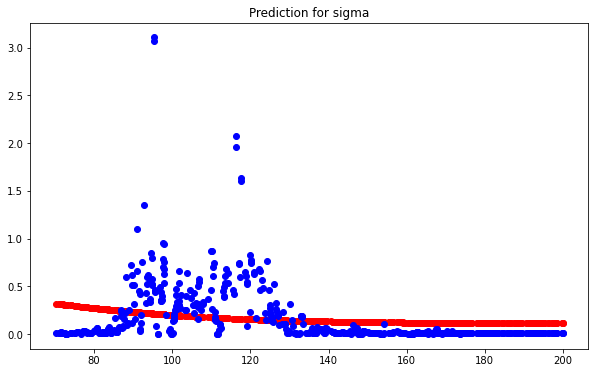

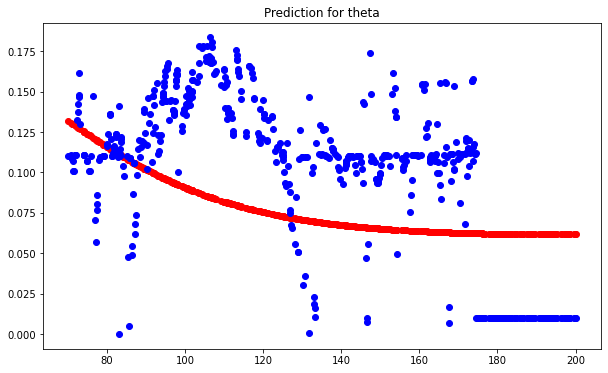

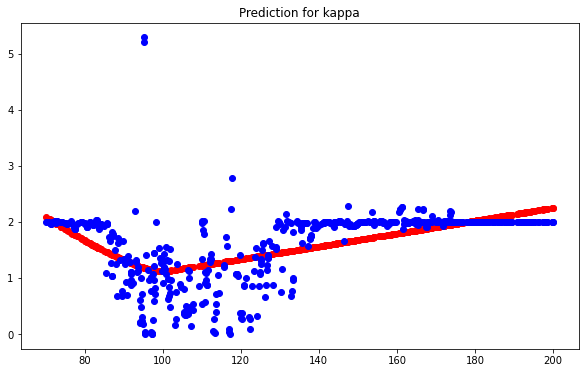

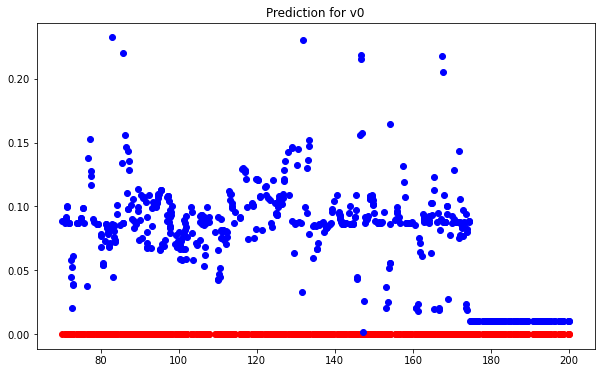

In [38]:
# Evaluer et plotter les résultats 

# Pour sigma
y_hat = model.predict(df_test.loc[:,['Strike', 'Synthetic Prices']])
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], y_hat[:,0], label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['sigma'], label = 'sigma',color='b')
plt.title("Prediction for sigma")

# Pour theta
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], y_hat[:,1], label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['theta'], label = 'sigma',color='b')
plt.title("Prediction for theta")

# Pour Kappa
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], y_hat[:,2], label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['kappa'], label = 'sigma',color='b')
plt.title("Prediction for kappa")

# Pour V0
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(df_test['Strike'], y_hat[:,3], label = 'NN Prediction',color='red')
plt.scatter(df_test['Strike'], df_test['v0'], label = 'sigma',color='b')
plt.title("Prediction for v0")

### Commentaire :
On voit que les résultats obtenus sont plus pires pour les deux paramètres (sigma, theta, kappa et v0) comparant avec le premier cas. Cela revient au problème des données qui sont moins précis et qui ont été alimentés au modèle parce que la minimisation est moins précis et il y'a une multivariété des paramètres à équilibrer.

# Question3

Dans cette exercice on va prédire en utulisant gpr et NN les prix de Call Barrière european suivant les deux modèles de BS et
de Heston. Au début on crée l'option barrière pour chaque modèle en utulisant la méthode de Monte-Carlo puis pour chaque
chaque modèle on refait comme la question 1 pour la construction, l'entrainement et l'évaluation des modèles de GPR et de NN

## BS Option Barrière

In [39]:
# La fonction de Black sholes model
def bsformula(cp, s, k, rf, t, v, div):
        """ Price an option using the Black-Scholes model.
        cp: +1/-1 for call/put
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        """

        d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)

        optprice = (cp*s*np.exp(-div*t)*st.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*st.norm.cdf(cp*d2))
        delta = cp*st.norm.cdf(cp*d1)
        vega  = s*np.sqrt(t)*st.norm.pdf(d1)
        return optprice, delta, vega

In [40]:
# La fonction pour l'option barrière pour BS Model avec MC
def BSOptionBarrier(r,S0,K,sigma,T, barrier, n_steps,n_simulation):
    dt = T / n_steps
    S = sp.zeros([int(n_steps)], dtype=float)
    time_ = range(0, int(n_steps), 2)
    c = bsformula(1,S0, K, r, T, sigma, 0)[0]
    sp.random.seed(124)
    outTotal, inTotal = 0., 0.
    n_out, n_in = 0, 0
    for j in range(0, n_simulation):
        S[0] = S0
        inStatus = False
        outStatus = True
    for i in time_[:-1]:
        e = sp.random.normal()
        S[i + 1] = S[i] * exp((r - 0.5 * pow(sigma, 1)) * dt + sigma * sp.sqrt(dt) * e)
        if S[i + 1] >= barrier:
            outStatus = False
            inStatus = True
        if outStatus:
            outTotal += c;
            n_out += 1
        else:
            inTotal += c;
            n_in += 1
        S = sp.zeros(int(n_steps)) + barrier
        upOutCall = outTotal/n_simulation
        upInCall = inTotal#/n_simulation
        #print('up_and_out_call=' + str(upOutCall))
        #print('up_and_in_call=' + str(upInCall))
        return upInCall, upOutCall

In [41]:
# Les paramètres 
r = 0.05    # risk-free rate
S0= 50      # Underlying spot
K = 150    # Call strike
sigma = 0.3 # implied volatility
T = 2.0     # Time to maturity
barrier = 30.0
n_steps = 30
sp.random.seed(125)
n_simulation = 10**5

### GPR

In [42]:
BS_Barrier_Call=lambda s,t:BSOptionBarrier(r,s*150+(1-s)*50,K,sigma,t*7+(1-t)*1, barrier, n_steps,n_simulation)[0]

In [43]:
# La construction des données d'entrainement
training_number = 200   # Number of training samples
testing_number =  1000  # Number of testing samples

train_s = torch.rand(1,training_number)
train_t = torch.rand(1,training_number)
test_s = torch.rand(1,testing_number)
test_t = torch.rand(1,testing_number)

BS_price_train=[]
for i in range(training_number):
    BS_price=BS_Barrier_Call(np.array(train_s)[0][i], np.array(train_t)[0][i])
    BS_price_train.append(BS_price)
    
BS_price_test=[]
for i in range(testing_number):
    BS_price=BS_Barrier_Call(np.array(test_s)[0][i], np.array(test_t)[0][i])
    BS_price_test.append(BS_price)
    
train_x=torch.stack([train_s, train_t], -1)
test_x=torch.stack([test_s, test_t], -1)
train_y=torch.FloatTensor(np.array(BS_price_train).reshape(1, training_number))
test_y=torch.FloatTensor(np.array(BS_price_test).reshape(1, testing_number))

In [44]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=1
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)), num_tasks=1, rank=1
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [45]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=1)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.lengthscale, likelihood.noise))
    
    optimizer.step()

Iter 1/100 - Loss: 10.938 lengthscale: 0.693 noise: 0.693
Iter 2/100 - Loss: 9.406 lengthscale: 0.644 noise: 0.744
Iter 3/100 - Loss: 8.161 lengthscale: 0.600 noise: 0.797
Iter 4/100 - Loss: 7.157 lengthscale: 0.561 noise: 0.850
Iter 5/100 - Loss: 6.346 lengthscale: 0.528 noise: 0.902
Iter 6/100 - Loss: 5.685 lengthscale: 0.501 noise: 0.952
Iter 7/100 - Loss: 5.143 lengthscale: 0.479 noise: 1.000
Iter 8/100 - Loss: 4.693 lengthscale: 0.463 noise: 1.042
Iter 9/100 - Loss: 4.318 lengthscale: 0.451 noise: 1.081
Iter 10/100 - Loss: 4.002 lengthscale: 0.443 noise: 1.113
Iter 11/100 - Loss: 3.735 lengthscale: 0.438 noise: 1.140
Iter 12/100 - Loss: 3.508 lengthscale: 0.435 noise: 1.161
Iter 13/100 - Loss: 3.314 lengthscale: 0.434 noise: 1.176
Iter 14/100 - Loss: 3.147 lengthscale: 0.435 noise: 1.186
Iter 15/100 - Loss: 3.003 lengthscale: 0.437 noise: 1.189
Iter 16/100 - Loss: 2.878 lengthscale: 0.441 noise: 1.188
Iter 17/100 - Loss: 2.768 lengthscale: 0.445 noise: 1.182
Iter 18/100 - Loss: 2.

In [46]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat = likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

In [47]:
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
lengthscale = model.covar_module.data_covar_module.base_kernel.lengthscale
sigma_2_n = likelihood.noise
nu = model.covar_module.data_covar_module.base_kernel.nu
print(lengthscale, sigma_2_n, nu, Omega, sep='\n')

tensor([[0.9954]], grad_fn=<SoftplusBackward0>)
tensor([0.0008], grad_fn=<AddBackward0>)
2.5
[[18.280914]]


Text(0.5, 1.0, 'Real and Predicted BS Barrier Call Prices in respect to T')

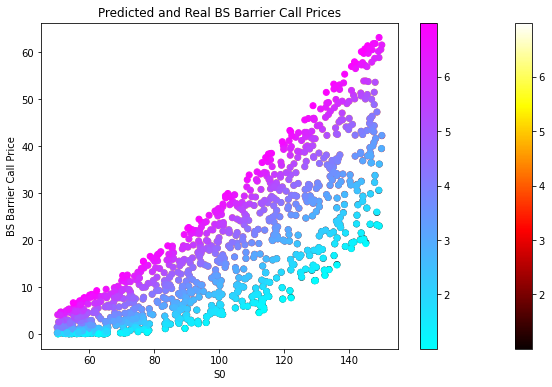

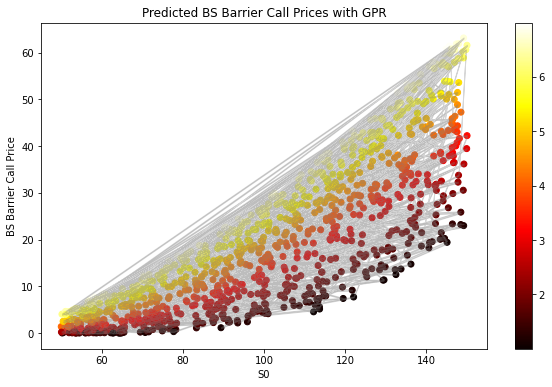

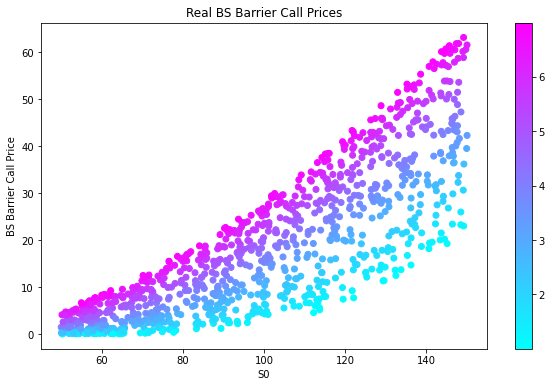

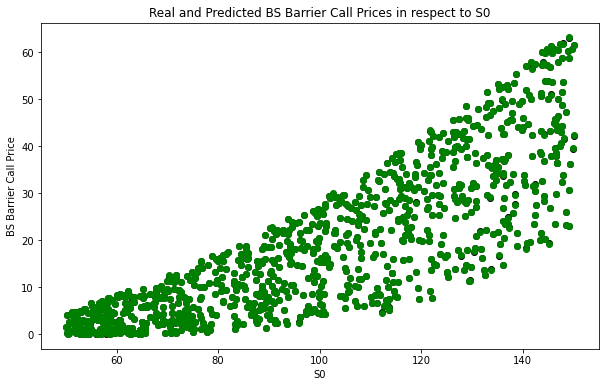

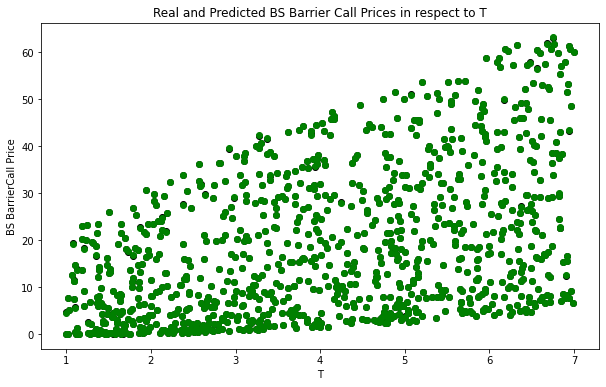

In [48]:
# Plotter les résultats 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='hot')
plt.colorbar()
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='cool'
            )
plt.xlabel('S0')
plt.ylabel('BS Barrier Call Price')
plt.title("Predicted and Real BS Barrier Call Prices")
plt.colorbar()

# Predicted values
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='hot')

plt.fill_between(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
                 lower[0,:,0].detach().numpy(), 
                 upper[0,:,0].detach().numpy(), 
                 color = 'grey', 
                 alpha=0.3)
plt.xlabel('S0')
plt.ylabel('BS Barrier Call Price')
plt.title("Predicted BS Barrier Call Prices with GPR")
plt.colorbar()

# Real Values 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='cool'
            )
plt.xlabel('S0')
plt.ylabel('BS Barrier Call Price')
plt.title("Real BS Barrier Call Prices")
plt.colorbar()
# Comparaison respecting to S0
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            color="black")
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            color="green")
plt.xlabel('S0')
plt.ylabel('BS Barrier Call Price')
plt.title("Real and Predicted BS Barrier Call Prices in respect to S0")
# Comparaison respecting to T
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            color="black")
plt.scatter(np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            color="green")
plt.xlabel('T')
plt.ylabel('BS BarrierCall Price')
plt.title("Real and Predicted BS Barrier Call Prices in respect to T")

### Commentaires : 
On remarque que les prix sont prédites d'une manière assez précise avec le gpr sauf pour quelques petites différences. Cela revient au fait qu'on n'a pas utulisé trop de paramètres ce qui n'empeche pas dans ce cas le gpr de donner des valeurs précises et dans l'intervalle de confiance.

### NN

In [49]:
BS_Barrier_Call=lambda s,t:BSOptionBarrier(r,s,K,sigma,t, barrier, n_steps,n_simulation)[0]

In [50]:
# Construction des données de train et de test
training_number = 500   # Number of training samples
testing_number =  200  # Number of testing samples

train_s=torch.FloatTensor(np.random.uniform(50,150,training_number))
train_t=torch.FloatTensor(np.random.uniform(1,7,training_number))
test_s=torch.FloatTensor(np.random.uniform(50,150,testing_number))
test_t=torch.FloatTensor(np.random.uniform(1,7,testing_number))

BS_price_train=[BS_Barrier_Call(np.array(train_s)[i], np.array(train_t)[i]) for i in range(training_number)]
BS_price_test=[BS_Barrier_Call(np.array(test_s)[i], np.array(test_t)[i]) for i in range(testing_number)]

train_x=torch.stack([train_s, train_t], -1)
test_x=torch.stack([test_s, test_t], -1)

train_y=torch.FloatTensor(np.array(BS_price_train))
test_y=torch.FloatTensor(np.array(BS_price_test))

In [51]:
# créer la dataframe de données 
df = pd.DataFrame(np.array(train_x[:,0]))
df.columns=['Stock Price']
df['Strike Price']=K*np.ones(training_number)
df['Maturity']=np.array(train_x[:,1])
df['Dividends']=0*np.ones(training_number)
df['Volatility']=sigma*np.ones(training_number)
df['Risk-free']=r*np.ones(training_number)
df['Call Price']=np.array(train_y)


df['Stock Price'] = df['Stock Price']/df['Strike Price']
df['Call Price']  = df['Call Price'] /df['Strike Price']

df.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0.714876,150.0,1.554494,0.0,0.3,0.05,0.043804
1,0.638827,150.0,4.127363,0.0,0.3,0.05,0.099530
2,0.589804,150.0,4.264141,0.0,0.3,0.05,0.081505
3,0.515993,150.0,6.144079,0.0,0.3,0.05,0.090758
4,0.778642,150.0,2.818182,0.0,0.3,0.05,0.122536


In [52]:
# La création du modèle NN 
nodes = 100
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(nodes,  activation='relu', kernel_constraint=non_neg())) 
model.add(Dropout(0.25))
model.add(Dense(1 ,activation='elu', kernel_constraint=non_neg()))
model.compile(loss='mse',optimizer='rmsprop') 

# L'entrainement du modèle
history = model.fit(df.loc[:,['Stock Price', 'Maturity']], 
                    df['Call Price'], 
                    batch_size=64, 
                    epochs=500, 
                    validation_split=0.1, 
                    verbose=2)


Epoch 1/500
8/8 - 0s - loss: 3.1458 - val_loss: 2.6509 - 319ms/epoch - 40ms/step
Epoch 2/500
8/8 - 0s - loss: 2.2048 - val_loss: 1.8085 - 33ms/epoch - 4ms/step
Epoch 3/500
8/8 - 0s - loss: 1.5251 - val_loss: 1.3072 - 24ms/epoch - 3ms/step
Epoch 4/500
8/8 - 0s - loss: 1.0968 - val_loss: 0.8777 - 22ms/epoch - 3ms/step
Epoch 5/500
8/8 - 0s - loss: 0.7657 - val_loss: 0.6338 - 22ms/epoch - 3ms/step
Epoch 6/500
8/8 - 0s - loss: 0.5542 - val_loss: 0.4211 - 21ms/epoch - 3ms/step
Epoch 7/500
8/8 - 0s - loss: 0.3749 - val_loss: 0.3007 - 21ms/epoch - 3ms/step
Epoch 8/500
8/8 - 0s - loss: 0.2572 - val_loss: 0.2116 - 21ms/epoch - 3ms/step
Epoch 9/500
8/8 - 0s - loss: 0.1876 - val_loss: 0.1418 - 21ms/epoch - 3ms/step
Epoch 10/500
8/8 - 0s - loss: 0.1217 - val_loss: 0.0904 - 20ms/epoch - 3ms/step
Epoch 11/500
8/8 - 0s - loss: 0.0743 - val_loss: 0.0540 - 24ms/epoch - 3ms/step
Epoch 12/500
8/8 - 0s - loss: 0.0489 - val_loss: 0.0327 - 22ms/epoch - 3ms/step
Epoch 13/500
8/8 - 0s - loss: 0.0326 - val_loss

Epoch 100/500
8/8 - 0s - loss: 6.7196e-04 - val_loss: 0.0012 - 22ms/epoch - 3ms/step
Epoch 101/500
8/8 - 0s - loss: 7.1304e-04 - val_loss: 1.6970e-04 - 22ms/epoch - 3ms/step
Epoch 102/500
8/8 - 0s - loss: 8.5941e-04 - val_loss: 2.0148e-04 - 22ms/epoch - 3ms/step
Epoch 103/500
8/8 - 0s - loss: 5.7928e-04 - val_loss: 0.0012 - 23ms/epoch - 3ms/step
Epoch 104/500
8/8 - 0s - loss: 7.3032e-04 - val_loss: 5.7344e-04 - 22ms/epoch - 3ms/step
Epoch 105/500
8/8 - 0s - loss: 8.4034e-04 - val_loss: 0.0030 - 22ms/epoch - 3ms/step
Epoch 106/500
8/8 - 0s - loss: 9.1148e-04 - val_loss: 2.3611e-04 - 22ms/epoch - 3ms/step
Epoch 107/500
8/8 - 0s - loss: 5.3831e-04 - val_loss: 0.0024 - 23ms/epoch - 3ms/step
Epoch 108/500
8/8 - 0s - loss: 8.6888e-04 - val_loss: 4.0760e-04 - 22ms/epoch - 3ms/step
Epoch 109/500
8/8 - 0s - loss: 5.1379e-04 - val_loss: 1.6136e-04 - 22ms/epoch - 3ms/step
Epoch 110/500
8/8 - 0s - loss: 7.5402e-04 - val_loss: 6.5918e-04 - 22ms/epoch - 3ms/step
Epoch 111/500
8/8 - 0s - loss: 5.9711

Epoch 194/500
8/8 - 0s - loss: 4.6236e-04 - val_loss: 1.7309e-04 - 21ms/epoch - 3ms/step
Epoch 195/500
8/8 - 0s - loss: 5.6858e-04 - val_loss: 7.9605e-04 - 21ms/epoch - 3ms/step
Epoch 196/500
8/8 - 0s - loss: 4.4801e-04 - val_loss: 0.0016 - 21ms/epoch - 3ms/step
Epoch 197/500
8/8 - 0s - loss: 5.9914e-04 - val_loss: 0.0022 - 22ms/epoch - 3ms/step
Epoch 198/500
8/8 - 0s - loss: 6.6155e-04 - val_loss: 9.9429e-05 - 21ms/epoch - 3ms/step
Epoch 199/500
8/8 - 0s - loss: 3.5228e-04 - val_loss: 3.5738e-04 - 23ms/epoch - 3ms/step
Epoch 200/500
8/8 - 0s - loss: 4.0954e-04 - val_loss: 1.7072e-04 - 22ms/epoch - 3ms/step
Epoch 201/500
8/8 - 0s - loss: 6.2238e-04 - val_loss: 1.2716e-04 - 23ms/epoch - 3ms/step
Epoch 202/500
8/8 - 0s - loss: 3.2194e-04 - val_loss: 5.2851e-04 - 21ms/epoch - 3ms/step
Epoch 203/500
8/8 - 0s - loss: 4.9435e-04 - val_loss: 7.6454e-04 - 21ms/epoch - 3ms/step
Epoch 204/500
8/8 - 0s - loss: 4.9971e-04 - val_loss: 1.0541e-04 - 21ms/epoch - 3ms/step
Epoch 205/500
8/8 - 0s - loss

Epoch 287/500
8/8 - 0s - loss: 4.0955e-04 - val_loss: 8.8535e-05 - 21ms/epoch - 3ms/step
Epoch 288/500
8/8 - 0s - loss: 3.1860e-04 - val_loss: 1.5108e-04 - 23ms/epoch - 3ms/step
Epoch 289/500
8/8 - 0s - loss: 4.6371e-04 - val_loss: 7.9436e-05 - 23ms/epoch - 3ms/step
Epoch 290/500
8/8 - 0s - loss: 4.3634e-04 - val_loss: 9.3017e-05 - 20ms/epoch - 3ms/step
Epoch 291/500
8/8 - 0s - loss: 2.7422e-04 - val_loss: 2.3994e-04 - 22ms/epoch - 3ms/step
Epoch 292/500
8/8 - 0s - loss: 6.1592e-04 - val_loss: 7.9428e-04 - 21ms/epoch - 3ms/step
Epoch 293/500
8/8 - 0s - loss: 4.6684e-04 - val_loss: 6.9007e-04 - 21ms/epoch - 3ms/step
Epoch 294/500
8/8 - 0s - loss: 3.1308e-04 - val_loss: 0.0017 - 21ms/epoch - 3ms/step
Epoch 295/500
8/8 - 0s - loss: 5.2991e-04 - val_loss: 8.2002e-05 - 21ms/epoch - 3ms/step
Epoch 296/500
8/8 - 0s - loss: 3.0441e-04 - val_loss: 1.6760e-04 - 22ms/epoch - 3ms/step
Epoch 297/500
8/8 - 0s - loss: 6.4202e-04 - val_loss: 8.0656e-05 - 23ms/epoch - 3ms/step
Epoch 298/500
8/8 - 0s - 

Epoch 380/500
8/8 - 0s - loss: 3.3550e-04 - val_loss: 6.0834e-04 - 22ms/epoch - 3ms/step
Epoch 381/500
8/8 - 0s - loss: 5.8534e-04 - val_loss: 8.5612e-05 - 24ms/epoch - 3ms/step
Epoch 382/500
8/8 - 0s - loss: 2.6161e-04 - val_loss: 9.8401e-05 - 20ms/epoch - 2ms/step
Epoch 383/500
8/8 - 0s - loss: 3.8351e-04 - val_loss: 1.2951e-04 - 21ms/epoch - 3ms/step
Epoch 384/500
8/8 - 0s - loss: 3.3375e-04 - val_loss: 4.2717e-04 - 21ms/epoch - 3ms/step
Epoch 385/500
8/8 - 0s - loss: 3.3684e-04 - val_loss: 1.4593e-04 - 22ms/epoch - 3ms/step
Epoch 386/500
8/8 - 0s - loss: 4.1650e-04 - val_loss: 3.6437e-04 - 22ms/epoch - 3ms/step
Epoch 387/500
8/8 - 0s - loss: 2.9644e-04 - val_loss: 7.4763e-05 - 22ms/epoch - 3ms/step
Epoch 388/500
8/8 - 0s - loss: 4.8533e-04 - val_loss: 7.3738e-05 - 21ms/epoch - 3ms/step
Epoch 389/500
8/8 - 0s - loss: 2.6885e-04 - val_loss: 2.9365e-04 - 22ms/epoch - 3ms/step
Epoch 390/500
8/8 - 0s - loss: 3.4886e-04 - val_loss: 1.1358e-04 - 22ms/epoch - 3ms/step
Epoch 391/500
8/8 - 0

Epoch 473/500
8/8 - 0s - loss: 4.0871e-04 - val_loss: 6.5972e-04 - 20ms/epoch - 2ms/step
Epoch 474/500
8/8 - 0s - loss: 3.8592e-04 - val_loss: 8.8624e-04 - 23ms/epoch - 3ms/step
Epoch 475/500
8/8 - 0s - loss: 4.8046e-04 - val_loss: 6.8604e-04 - 21ms/epoch - 3ms/step
Epoch 476/500
8/8 - 0s - loss: 3.2936e-04 - val_loss: 1.1495e-04 - 23ms/epoch - 3ms/step
Epoch 477/500
8/8 - 0s - loss: 3.0196e-04 - val_loss: 4.3555e-04 - 23ms/epoch - 3ms/step
Epoch 478/500
8/8 - 0s - loss: 4.0987e-04 - val_loss: 3.5606e-04 - 21ms/epoch - 3ms/step
Epoch 479/500
8/8 - 0s - loss: 3.1851e-04 - val_loss: 0.0011 - 22ms/epoch - 3ms/step
Epoch 480/500
8/8 - 0s - loss: 3.8742e-04 - val_loss: 0.0012 - 22ms/epoch - 3ms/step
Epoch 481/500
8/8 - 0s - loss: 5.2174e-04 - val_loss: 7.5505e-05 - 22ms/epoch - 3ms/step
Epoch 482/500
8/8 - 0s - loss: 3.7096e-04 - val_loss: 0.0010 - 22ms/epoch - 3ms/step
Epoch 483/500
8/8 - 0s - loss: 4.9247e-04 - val_loss: 1.4058e-04 - 22ms/epoch - 3ms/step
Epoch 484/500
8/8 - 0s - loss: 2.

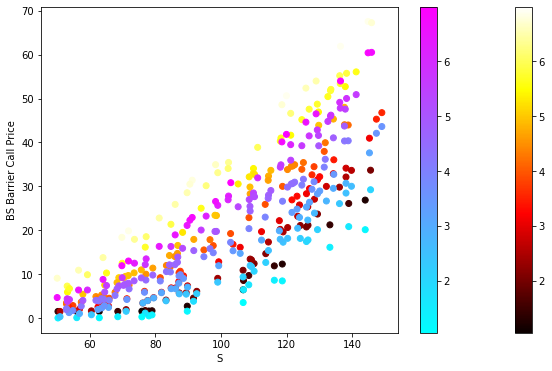

In [54]:
# Evaluer et plotter les résultats 
test=np.array(test_x)[:]
test[:,0]=test[:,0]/K
y_hat = model.predict(np.array(test))*K

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[:,0]), y_hat, label = 'NN Prediction',c=np.array(test_x[:,1]),cmap='hot')
plt.colorbar()
plt.scatter(np.array(test_x[:,0]), np.array(test_y),c=np.array(test_x[:,1]),cmap='cool', label = 'Analytical Model')
plt.xlabel('S')
plt.ylabel('BS Barrier Call Price')
plt.colorbar()

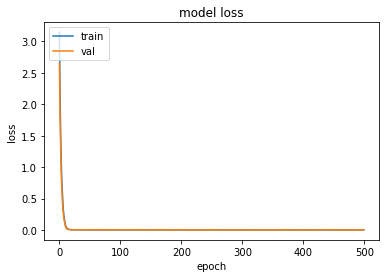

In [55]:
# Plotter la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Commentaires :
On remarque bien que le modèle donne des résultats précis avec des loss très basses mais moins bon que le modèle de gpr.

## Heston Barrier Call 

In [56]:
# Fonction pour calculer le prix du call d'option barrière suivant le modèle de Heston
def HestonOptionBarrier(r,T,K,S0, v0, kappa, theta, sigma, payoff, exercise, barrier, n_steps,n_simulation):
    dt = T / n_steps
    S = sp.zeros([int(n_steps)], dtype=float)
    time_ = range(0, int(n_steps), 2)
    c = HestonFormula(r,T,K,S0, v0, kappa, theta, sigma, payoff, exercise)
    sp.random.seed(124)
    outTotal, inTotal = 0., 0.
    n_out, n_in = 0, 0
    for j in range(0, n_simulation):
        S[0] = S0
        inStatus = False
        outStatus = True
    for i in time_[:-1]:
        e = sp.random.normal()
        S[i + 1] = S[i] * exp((r - 0.5 * pow(sigma, 1)) * dt + sigma * sp.sqrt(dt) * e)
        if S[i + 1] >= barrier:
            outStatus = False
            inStatus = True
        if outStatus:
            outTotal += c;
            n_out += 1
        else:
            inTotal += c;
            n_in += 1
        S = sp.zeros(int(n_steps)) + barrier
        upOutCall = outTotal/n_simulation
        upInCall = inTotal#/n_simulation
        #print('up_and_out_call=' + str(upOutCall))
        #print('up_and_in_call=' + str(upInCall))
        return upInCall, upOutCall

In [57]:
# Les paramètres 
r = 0.05    # risk-free rate
S0= 50      # Underlying spot
K = 150    # Call strike
sigma = 0.3 # implied volatility
T = 2.0     # Time to maturity
v0=0.1
kappa=2
theta=0.1
sigma=0.2
barrier = 30.0
n_steps = 30
sp.random.seed(125)
n_simulation = 10**5

### GPR

In [58]:
# Fonction de prix de call d'option barrier du modèle de Heston
Heston_Barrier_Call=lambda s,t:HestonOptionBarrier(r,t*7+(1-t)*1,K,s*150+(1-s)*50, 
                                                   v0, kappa, theta, sigma, payoff, 
                                                    exercise, barrier, n_steps,n_simulation)[0]

In [59]:
# La construction des données d'entrainement et de teste
training_number = 200   # Number of training samples
testing_number =  1000  # Number of testing samples

train_s = torch.rand(1,training_number)
train_t = torch.rand(1,training_number)
test_s = torch.rand(1,testing_number)
test_t = torch.rand(1,testing_number)

Heston_price_train=[]
for i in range(training_number):
    hest_price=Heston_Barrier_Call(np.array(train_s)[0][i], np.array(train_t)[0][i])
    Heston_price_train.append(hest_price)
    
Heston_price_test=[]
for i in range(testing_number):
    hest_price=Heston_Barrier_Call(np.array(test_s)[0][i], np.array(test_t)[0][i])
    Heston_price_test.append(hest_price)
    
train_x=torch.stack([train_s, train_t], -1)
test_x=torch.stack([test_s, test_t], -1)
train_y=torch.FloatTensor(np.array(Heston_price_train).reshape(1, training_number))
test_y=torch.FloatTensor(np.array(Heston_price_test).reshape(1, testing_number))

In [60]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=1
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)), num_tasks=1, rank=1
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [61]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=1)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.lengthscale, likelihood.noise))
    
    optimizer.step()

Iter 1/100 - Loss: 7.881 lengthscale: 0.693 noise: 0.693
Iter 2/100 - Loss: 6.806 lengthscale: 0.644 noise: 0.744
Iter 3/100 - Loss: 5.963 lengthscale: 0.600 noise: 0.796
Iter 4/100 - Loss: 5.303 lengthscale: 0.561 noise: 0.846
Iter 5/100 - Loss: 4.782 lengthscale: 0.528 noise: 0.892
Iter 6/100 - Loss: 4.365 lengthscale: 0.501 noise: 0.931
Iter 7/100 - Loss: 4.023 lengthscale: 0.480 noise: 0.962
Iter 8/100 - Loss: 3.738 lengthscale: 0.465 noise: 0.983
Iter 9/100 - Loss: 3.496 lengthscale: 0.454 noise: 0.995
Iter 10/100 - Loss: 3.288 lengthscale: 0.448 noise: 0.996
Iter 11/100 - Loss: 3.106 lengthscale: 0.444 noise: 0.988
Iter 12/100 - Loss: 2.946 lengthscale: 0.444 noise: 0.972
Iter 13/100 - Loss: 2.804 lengthscale: 0.445 noise: 0.949
Iter 14/100 - Loss: 2.677 lengthscale: 0.449 noise: 0.920
Iter 15/100 - Loss: 2.563 lengthscale: 0.454 noise: 0.886
Iter 16/100 - Loss: 2.459 lengthscale: 0.460 noise: 0.849
Iter 17/100 - Loss: 2.363 lengthscale: 0.467 noise: 0.810
Iter 18/100 - Loss: 2.2

In [62]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat = likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

In [63]:
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
lengthscale = model.covar_module.data_covar_module.base_kernel.lengthscale
sigma_2_n = likelihood.noise
nu = model.covar_module.data_covar_module.base_kernel.nu
print(lengthscale, sigma_2_n, nu, Omega, sep='\n')

tensor([[1.1319]], grad_fn=<SoftplusBackward0>)
tensor([0.0003], grad_fn=<AddBackward0>)
2.5
[[21.517294]]


Text(0.5, 1.0, 'Real and Predicted Heston Barrier Call Prices in respect to T')

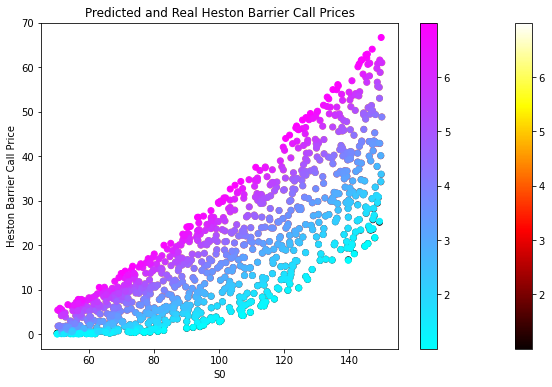

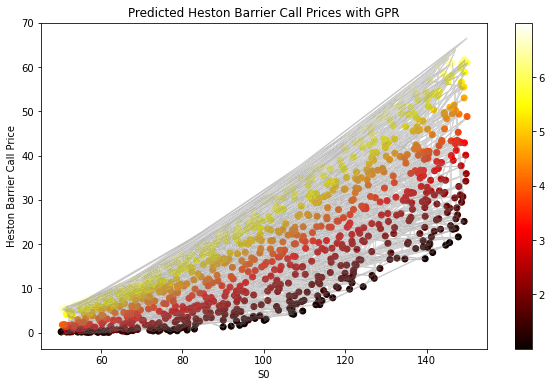

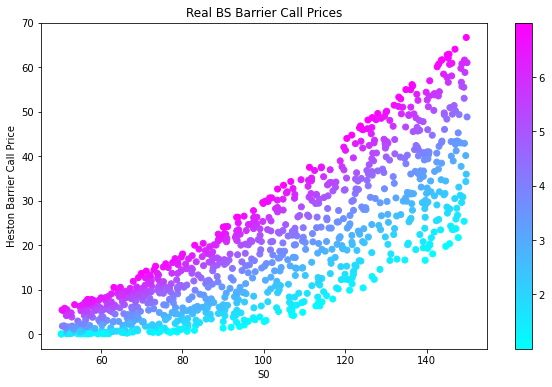

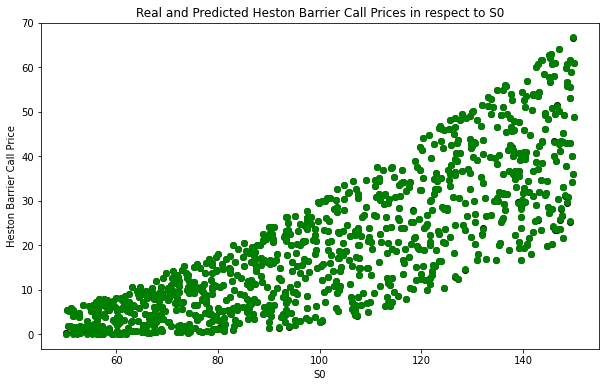

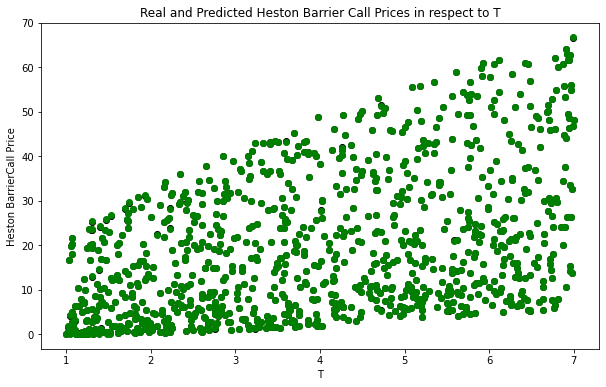

In [64]:
# Plotter les résultats 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='hot')
plt.colorbar()
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='cool'
            )
plt.xlabel('S0')
plt.ylabel('Heston Barrier Call Price')
plt.title("Predicted and Real Heston Barrier Call Prices")
plt.colorbar()

# Predicted values
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='hot')

plt.fill_between(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
                 lower[0,:,0].detach().numpy(), 
                 upper[0,:,0].detach().numpy(), 
                 color = 'grey', 
                 alpha=0.3)
plt.xlabel('S0')
plt.ylabel('Heston Barrier Call Price')
plt.title("Predicted Heston Barrier Call Prices with GPR")
plt.colorbar()

# Real Values 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            c=np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1,
            cmap='cool'
            )
plt.xlabel('S0')
plt.ylabel('Heston Barrier Call Price')
plt.title("Real BS Barrier Call Prices")
plt.colorbar()
# Comparaison respecting to S0
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            color="black")
plt.scatter(np.array(test_x[0,:,0].flatten())*150+(1-np.array(test_x[0,:,0].flatten()))*50, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            color="green")
plt.xlabel('S0')
plt.ylabel('Heston Barrier Call Price')
plt.title("Real and Predicted Heston Barrier Call Prices in respect to S0")
# Comparaison respecting to T
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1, 
            np.array(y_hat.mean[0,:,0]), 
            label = 'GP Prediction',
            color="black")
plt.scatter(np.array(test_x[0,:,1].flatten())*7+(1-np.array(test_x[0,:,1].flatten()))*1, 
            np.array(test_y[0]), 
            label = 'Analytical Model',
            color="green")
plt.xlabel('T')
plt.ylabel('Heston BarrierCall Price')
plt.title("Real and Predicted Heston Barrier Call Prices in respect to T")

### Commentaires : 
On trouve des résultats similaires à la question 1. On voit bien selon les graphes que pratiquement les valeurs prédites par gpr sont collées parfaitement avec les valeurs réelles. Ce qui montre que le modèle est bien précis. Mais ce modèle de gpr marche bien parce que les paramètres utilisées ne sont pas beaucoup (2 paramètres S0 et T).

### NN

In [65]:
# Fonction pour le clacul de prix d'option barrier du modele de Heston
Heston_Barrier_Call=lambda s,t:HestonOptionBarrier(r,t,K,s, 
                                                   v0, kappa, theta, sigma, payoff, 
                                                    exercise, barrier, n_steps,n_simulation)[0]

In [66]:
# Données d'entrainement et de test
training_number = 500   # Number of training samples
testing_number =  200  # Number of testing samples

train_s=torch.FloatTensor(np.random.uniform(50,150,training_number))
train_t=torch.FloatTensor(np.random.uniform(1,7,training_number))
test_s=torch.FloatTensor(np.random.uniform(50,150,testing_number))
test_t=torch.FloatTensor(np.random.uniform(1,7,testing_number))

Heston_price_train=[Heston_Barrier_Call(np.array(train_s)[i], np.array(train_t)[i]) for i in range(training_number)]
Heston_price_test=[Heston_Barrier_Call(np.array(test_s)[i], np.array(test_t)[i]) for i in range(testing_number)]

train_x=torch.stack([train_s, train_t], -1)
test_x=torch.stack([test_s, test_t], -1)

train_y=torch.FloatTensor(np.array(Heston_price_train))
test_y=torch.FloatTensor(np.array(Heston_price_test))

In [67]:
# Dataframe des données 
df = pd.DataFrame(np.array(train_x[:,0]))
df.columns=['Stock Price']
df['Strike Price']=K*np.ones(training_number)
df['Maturity']=np.array(train_x[:,1])
df['Dividends']=0*np.ones(training_number)
df['Volatility']=sigma*np.ones(training_number)
df['Risk-free']=r*np.ones(training_number)
df['Call Price']=np.array(train_y)


df['Stock Price'] = df['Stock Price']/df['Strike Price']
df['Call Price']  = df['Call Price'] /df['Strike Price']

df.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0.714876,150.0,1.554494,0.0,0.2,0.05,0.048682
1,0.638827,150.0,4.127363,0.0,0.2,0.05,0.107524
2,0.589804,150.0,4.264141,0.0,0.2,0.05,0.088950
3,0.515993,150.0,6.144079,0.0,0.2,0.05,0.098739
4,0.778642,150.0,2.818182,0.0,0.2,0.05,0.130445


In [68]:
# Modèle de NN
nodes = 100
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(nodes,  activation='relu', kernel_constraint=non_neg())) 
model.add(Dropout(0.25))
model.add(Dense(1 ,activation='elu', kernel_constraint=non_neg()))
model.compile(loss='mse',optimizer='rmsprop') 

# Entrainement de NN
history = model.fit(df.loc[:,['Stock Price', 'Maturity']], 
                    df['Call Price'], 
                    batch_size=64, 
                    epochs=500, 
                    validation_split=0.1, 
                    verbose=2)


Epoch 1/500
8/8 - 0s - loss: 3.1727 - val_loss: 2.9585 - 361ms/epoch - 45ms/step
Epoch 2/500
8/8 - 0s - loss: 2.5235 - val_loss: 2.0352 - 28ms/epoch - 3ms/step
Epoch 3/500
8/8 - 0s - loss: 1.7688 - val_loss: 1.4375 - 25ms/epoch - 3ms/step
Epoch 4/500
8/8 - 0s - loss: 1.2284 - val_loss: 1.0768 - 24ms/epoch - 3ms/step
Epoch 5/500
8/8 - 0s - loss: 0.8981 - val_loss: 0.8063 - 26ms/epoch - 3ms/step
Epoch 6/500
8/8 - 0s - loss: 0.6687 - val_loss: 0.5833 - 26ms/epoch - 3ms/step
Epoch 7/500
8/8 - 0s - loss: 0.4916 - val_loss: 0.3972 - 24ms/epoch - 3ms/step
Epoch 8/500
8/8 - 0s - loss: 0.3597 - val_loss: 0.2671 - 23ms/epoch - 3ms/step
Epoch 9/500
8/8 - 0s - loss: 0.2288 - val_loss: 0.1854 - 26ms/epoch - 3ms/step
Epoch 10/500
8/8 - 0s - loss: 0.1585 - val_loss: 0.1177 - 25ms/epoch - 3ms/step
Epoch 11/500
8/8 - 0s - loss: 0.1087 - val_loss: 0.0809 - 24ms/epoch - 3ms/step
Epoch 12/500
8/8 - 0s - loss: 0.0714 - val_loss: 0.0512 - 25ms/epoch - 3ms/step
Epoch 13/500
8/8 - 0s - loss: 0.0494 - val_loss

Epoch 100/500
8/8 - 0s - loss: 7.3420e-04 - val_loss: 4.6471e-04 - 37ms/epoch - 5ms/step
Epoch 101/500
8/8 - 0s - loss: 7.6514e-04 - val_loss: 3.5904e-04 - 43ms/epoch - 5ms/step
Epoch 102/500
8/8 - 0s - loss: 8.8569e-04 - val_loss: 8.7013e-04 - 32ms/epoch - 4ms/step
Epoch 103/500
8/8 - 0s - loss: 6.4164e-04 - val_loss: 3.4437e-04 - 31ms/epoch - 4ms/step
Epoch 104/500
8/8 - 0s - loss: 8.3978e-04 - val_loss: 1.4546e-04 - 36ms/epoch - 4ms/step
Epoch 105/500
8/8 - 0s - loss: 5.8117e-04 - val_loss: 0.0024 - 34ms/epoch - 4ms/step
Epoch 106/500
8/8 - 0s - loss: 8.1518e-04 - val_loss: 1.6645e-04 - 33ms/epoch - 4ms/step
Epoch 107/500
8/8 - 0s - loss: 5.9563e-04 - val_loss: 0.0015 - 34ms/epoch - 4ms/step
Epoch 108/500
8/8 - 0s - loss: 8.9432e-04 - val_loss: 0.0018 - 30ms/epoch - 4ms/step
Epoch 109/500
8/8 - 0s - loss: 6.5831e-04 - val_loss: 0.0021 - 32ms/epoch - 4ms/step
Epoch 110/500
8/8 - 0s - loss: 7.2361e-04 - val_loss: 0.0013 - 32ms/epoch - 4ms/step
Epoch 111/500
8/8 - 0s - loss: 7.0061e-04

Epoch 194/500
8/8 - 0s - loss: 4.8932e-04 - val_loss: 1.2238e-04 - 23ms/epoch - 3ms/step
Epoch 195/500
8/8 - 0s - loss: 5.9109e-04 - val_loss: 0.0016 - 24ms/epoch - 3ms/step
Epoch 196/500
8/8 - 0s - loss: 7.2128e-04 - val_loss: 8.5915e-04 - 23ms/epoch - 3ms/step
Epoch 197/500
8/8 - 0s - loss: 5.0192e-04 - val_loss: 0.0013 - 23ms/epoch - 3ms/step
Epoch 198/500
8/8 - 0s - loss: 6.4186e-04 - val_loss: 9.1450e-04 - 24ms/epoch - 3ms/step
Epoch 199/500
8/8 - 0s - loss: 4.3955e-04 - val_loss: 1.1352e-04 - 23ms/epoch - 3ms/step
Epoch 200/500
8/8 - 0s - loss: 4.1166e-04 - val_loss: 1.2873e-04 - 29ms/epoch - 4ms/step
Epoch 201/500
8/8 - 0s - loss: 4.9691e-04 - val_loss: 0.0020 - 27ms/epoch - 3ms/step
Epoch 202/500
8/8 - 0s - loss: 5.0161e-04 - val_loss: 2.2675e-04 - 24ms/epoch - 3ms/step
Epoch 203/500
8/8 - 0s - loss: 5.9018e-04 - val_loss: 9.2015e-05 - 23ms/epoch - 3ms/step
Epoch 204/500
8/8 - 0s - loss: 4.5310e-04 - val_loss: 1.9504e-04 - 23ms/epoch - 3ms/step
Epoch 205/500
8/8 - 0s - loss: 5.

Epoch 287/500
8/8 - 0s - loss: 3.0358e-04 - val_loss: 1.9026e-04 - 23ms/epoch - 3ms/step
Epoch 288/500
8/8 - 0s - loss: 5.9994e-04 - val_loss: 4.9350e-04 - 23ms/epoch - 3ms/step
Epoch 289/500
8/8 - 0s - loss: 3.3210e-04 - val_loss: 2.2416e-04 - 23ms/epoch - 3ms/step
Epoch 290/500
8/8 - 0s - loss: 4.1175e-04 - val_loss: 0.0013 - 23ms/epoch - 3ms/step
Epoch 291/500
8/8 - 0s - loss: 4.8294e-04 - val_loss: 6.2860e-04 - 22ms/epoch - 3ms/step
Epoch 292/500
8/8 - 0s - loss: 3.5989e-04 - val_loss: 0.0013 - 23ms/epoch - 3ms/step
Epoch 293/500
8/8 - 0s - loss: 4.9168e-04 - val_loss: 8.5059e-05 - 22ms/epoch - 3ms/step
Epoch 294/500
8/8 - 0s - loss: 4.1110e-04 - val_loss: 8.0552e-05 - 23ms/epoch - 3ms/step
Epoch 295/500
8/8 - 0s - loss: 4.4850e-04 - val_loss: 0.0015 - 23ms/epoch - 3ms/step
Epoch 296/500
8/8 - 0s - loss: 5.3206e-04 - val_loss: 8.4764e-05 - 25ms/epoch - 3ms/step
Epoch 297/500
8/8 - 0s - loss: 3.3274e-04 - val_loss: 7.9519e-05 - 22ms/epoch - 3ms/step
Epoch 298/500
8/8 - 0s - loss: 3.

Epoch 380/500
8/8 - 0s - loss: 3.8025e-04 - val_loss: 4.7695e-04 - 23ms/epoch - 3ms/step
Epoch 381/500
8/8 - 0s - loss: 2.7654e-04 - val_loss: 2.4230e-04 - 25ms/epoch - 3ms/step
Epoch 382/500
8/8 - 0s - loss: 3.2735e-04 - val_loss: 1.4912e-04 - 23ms/epoch - 3ms/step
Epoch 383/500
8/8 - 0s - loss: 3.8247e-04 - val_loss: 0.0010 - 22ms/epoch - 3ms/step
Epoch 384/500
8/8 - 0s - loss: 3.4075e-04 - val_loss: 3.8750e-04 - 23ms/epoch - 3ms/step
Epoch 385/500
8/8 - 0s - loss: 4.2911e-04 - val_loss: 0.0015 - 22ms/epoch - 3ms/step
Epoch 386/500
8/8 - 0s - loss: 4.6164e-04 - val_loss: 6.5961e-04 - 21ms/epoch - 3ms/step
Epoch 387/500
8/8 - 0s - loss: 3.1157e-04 - val_loss: 2.7531e-04 - 20ms/epoch - 3ms/step
Epoch 388/500
8/8 - 0s - loss: 3.5273e-04 - val_loss: 1.3952e-04 - 23ms/epoch - 3ms/step
Epoch 389/500
8/8 - 0s - loss: 3.6620e-04 - val_loss: 1.8548e-04 - 24ms/epoch - 3ms/step
Epoch 390/500
8/8 - 0s - loss: 4.0864e-04 - val_loss: 4.5194e-04 - 22ms/epoch - 3ms/step
Epoch 391/500
8/8 - 0s - loss

Epoch 473/500
8/8 - 0s - loss: 3.3085e-04 - val_loss: 9.0806e-04 - 20ms/epoch - 3ms/step
Epoch 474/500
8/8 - 0s - loss: 3.7827e-04 - val_loss: 0.0010 - 23ms/epoch - 3ms/step
Epoch 475/500
8/8 - 0s - loss: 3.3854e-04 - val_loss: 2.6625e-04 - 23ms/epoch - 3ms/step
Epoch 476/500
8/8 - 0s - loss: 3.1135e-04 - val_loss: 1.1364e-04 - 23ms/epoch - 3ms/step
Epoch 477/500
8/8 - 0s - loss: 3.2831e-04 - val_loss: 3.0370e-04 - 25ms/epoch - 3ms/step
Epoch 478/500
8/8 - 0s - loss: 3.8168e-04 - val_loss: 2.9086e-04 - 22ms/epoch - 3ms/step
Epoch 479/500
8/8 - 0s - loss: 3.3547e-04 - val_loss: 8.2473e-05 - 28ms/epoch - 3ms/step
Epoch 480/500
8/8 - 0s - loss: 3.7121e-04 - val_loss: 1.5336e-04 - 25ms/epoch - 3ms/step
Epoch 481/500
8/8 - 0s - loss: 3.9747e-04 - val_loss: 3.8125e-04 - 22ms/epoch - 3ms/step
Epoch 482/500
8/8 - 0s - loss: 2.9570e-04 - val_loss: 1.0666e-04 - 20ms/epoch - 2ms/step
Epoch 483/500
8/8 - 0s - loss: 2.5732e-04 - val_loss: 1.2176e-04 - 22ms/epoch - 3ms/step
Epoch 484/500
8/8 - 0s - 

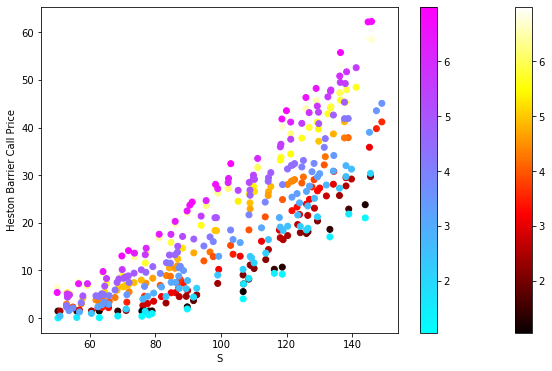

In [69]:
# Evaluer et plotter les résultats 
test=np.array(test_x)[:]
test[:,0]=test[:,0]/K
y_hat = model.predict(np.array(test))*K

plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.scatter(np.array(test_x[:,0]), y_hat, label = 'NN Prediction',c=np.array(test_x[:,1]),cmap='hot')
plt.colorbar()
plt.scatter(np.array(test_x[:,0]), np.array(test_y),c=np.array(test_x[:,1]),cmap='cool', label = 'Analytical Model')
plt.xlabel('S')
plt.ylabel('Heston Barrier Call Price')
plt.colorbar()

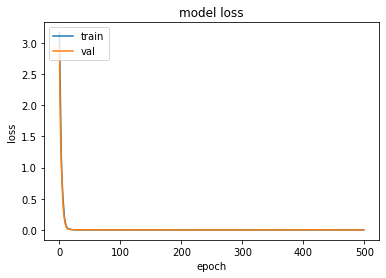

In [70]:
# Plotter la loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Commentaire :
On trouve des résultats similaires à la question 1. On remarque que la prédiction est moins précis que le modèle de GPR. Mais au niveau au niveau de Loss pour le train et le val est très petite et il n'y a pas une grande différence ce qui évite les problèmes d'overfitting et overfitting.